# Data Understanding and Feature Engineering

This Notebook ideally follows the `data_exploration` one.

## Autoreload

Autoreload allows the notebook to dynamically load code: if we update some helper functions *outside* of the notebook, we do not need to reload the notebook.

In [1]:
%load_ext autoreload
%autoreload 2

## Imports

In [2]:
# Uncomment the next line and install the package, in case you don't have it in your environment
#%pip install procyclingstats

In [3]:
import ast
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import procyclingstats as pcs
import re
import seaborn as sns
import sys



sys.path.append('../dataset/')
sys.path.append('../utility/')

from utility.data_understanding import *
from sklearn.linear_model import LinearRegression

In the `data_exploration` notebook we've assessed the quality of the data, also adressing some problems that were discovered.

### Dataframes

Motivated by the "imputation by scraping", we decided to retrieve data from (procyclingstats)[https://www.procyclingstats.com/index.php], which is a trusted source of data on cyclism. <br>
The `procyclingstats` notebook details the process of web scraping and data retrieval & augmentation.

In [4]:
cyclist_df = pd.read_csv(os.path.join('dataset','cyclists_new.csv'))
races_df = pd.read_csv(os.path.join('dataset','races_new.csv'))

The dataframes have to be preprocessed in order to be used

In [5]:
cyclist_df = cyclist_df.drop(columns=['Unnamed: 0'], errors='ignore')
cyclist_df['full_history'] = cyclist_df['full_history'].apply(ast.literal_eval)

In [6]:
races_df = races_df.drop(columns=['Unnamed: 0'], errors='ignore')

In [7]:
cyclist_df.head()

,_url,name,birth_year,weight,height,nationality,points_total,tot_seasons_attended,full_history
0,bruno-surra,Bruno Surra,1964.0,NaN,NaN,Italy,15.0,2,"[{'season': 1989, 'points': 14.0, 'rank': 828}..."
1,gerard-rue,Gérard Rué,1965.0,74.0,182.0,France,4717.0,11,"[{'season': 1997, 'points': 164.0, 'rank': 257..."
2,jan-maas,Jan Maas,1996.0,69.0,189.0,Netherlands,315.0,10,"[{'season': 2024, 'points': 30.0, 'rank': 990}..."
3,nathan-van-hooydonck,Nathan Van Hooydonck,1995.0,78.0,192.0,Belgium,953.0,9,"[{'season': 2023, 'points': 298.0, 'rank': 218..."
4,jose-felix-parra,José Félix Parra,1997.0,55.0,171.0,Spain,459.0,5,"[{'season': 2024, 'points': 197.0, 'rank': 317..."


In [8]:
races_df.head()

,_url,name,stage_type,points,uci_points,length,climb_total,profile,startlist_quality,average_temperature,date,position,cyclist,cyclist_age,is_tarmac,is_cobbled,is_gravel,cyclist_team,delta
0,tour-de-france/1978/stage-6,Tour de France,RR,100.0,NaN,162000.0,1101.0,1.0,1241,NaN,1978-07-05 04:02:24,0,sean-kelly,22.0,True,False,False,team/flandria-velda-lano-1978,0.0
1,tour-de-france/1978/stage-6,Tour de France,RR,70.0,NaN,162000.0,1101.0,1.0,1241,NaN,1978-07-05 04:02:24,1,gerrie-knetemann,27.0,True,False,False,team/ti-raleigh-mc-gregor-1978,0.0
2,tour-de-france/1978/stage-6,Tour de France,RR,50.0,NaN,162000.0,1101.0,1.0,1241,NaN,1978-07-05 04:02:24,2,rene-bittinger,24.0,True,False,False,team/flandria-velda-lano-1978,0.0
3,tour-de-france/1978/stage-6,Tour de France,RR,40.0,NaN,162000.0,1101.0,1.0,1241,NaN,1978-07-05 04:02:24,3,joseph-bruyere,30.0,True,False,False,team/c-a-1978,0.0
4,tour-de-france/1978/stage-6,Tour de France,RR,32.0,NaN,162000.0,1101.0,1.0,1241,NaN,1978-07-05 04:02:24,4,sven-ake-nilsson,27.0,True,False,False,team/miko-mercier-1978,0.0


## Added features

Let's discuss feature augmentation and feature engineering

### Added features (scraping)

We decided to add the following features, obtained by scraping the website:

For the `cyclists` dataset:
- `full_history`: the rider’s points per season history, obtained by reading the *PCS Ranking position per season* table 
- `points_total`: the rider's points accumulated throughout his career, obtained by summing the values in the aforementioned table
- `tot_season_attended`: the number of seasons ran by the cyclist
We decided not to use these features for now, because the data they contain comes from many cyclism disciplines, whereas the data at our disposal only includes road races.

For the `races` dataset:
- `stage_type`: can be RR (Road Race), ITT (Individual Time Trial), TTT (Team Time Trial). Obtained from the stage's webpage

The following changes were made, w.r.t. the original `races` dataset:
- The column `name` now has a unique identifier for each race. Races with identical `_url` prefix are the same race, but in the original dataset they might have been referred with multiple names
- The values in the `points` and `uci_points` column  are now those coming from the website. In the original dataset the (UCI) points were those of the first runner-up 
- The values in the `cyclist_team` column are now those coming from the website. 

In [9]:
cyclist_df = cyclist_df.drop(columns=['points_total', 'tot_seasons_attended','full_history'], errors='ignore')
cyclist_df.head()

,_url,name,birth_year,weight,height,nationality
0,bruno-surra,Bruno Surra,1964.0,NaN,NaN,Italy
1,gerard-rue,Gérard Rué,1965.0,74.0,182.0,France
2,jan-maas,Jan Maas,1996.0,69.0,189.0,Netherlands
3,nathan-van-hooydonck,Nathan Van Hooydonck,1995.0,78.0,192.0,Belgium
4,jose-felix-parra,José Félix Parra,1997.0,55.0,171.0,Spain


### Other added features (not scraped)

By comparing the values with the website, we noticed that the `date` column includes the date of the competition and the time the cyclist took to complete the race. So we disentangle such values.

In [10]:
races_df['time'] = races_df['date'].apply(lambda string: string.split(' ')[1])
races_df['date'] = races_df['date'].apply(lambda string: string.split(' ')[0])

In [11]:
races_df['time_seconds'] = races_df['time'].apply(lambda x: sum(int(t) * 60**i for i, t in enumerate(reversed(x.split(':')))))

Speed. The be all end all of any metric. We can obviously only calculate a mean of it. 

In [12]:
races_df['average_speed'] = races_df['length'] / races_df['time_seconds']

Let's check what insights we can gain from `average_speed`

In [13]:
races_df['average_speed'].describe()

count    604840.000000
mean         11.006316
std          10.611866
min           0.160154
25%          10.157743
50%          11.006766
75%          11.750510
max        5443.589744
Name: average_speed, dtype: float64

Cool it seems they let F-15s and snails participate in these races. For the scope of our analysis, we will not consider *anything* that goes faster than 40 m/s, which is the highest speed recorded, or slower than 3 m/s

In [14]:
races_df = races_df[races_df['average_speed'] < 40]
races_df = races_df[races_df['average_speed'] > 3]

Another feature is the ratio between the vertical meters and the length of the stage, in percentage. This is a "climb density", or steepness.

In [15]:
races_df['steepness'] = 100*races_df['climb_total']/races_df['length']

We also add the season in which a race is ran, by looking at the date.

In [16]:
# 0: winter, 1: spring, 2: summer, 3: fall
races_df['season'] = races_df['date'].apply(lambda data: (int(data.split('-')[1])//3)%4)

**TODO** Le gare hanno un certo ordine! Sarebbe figo trovarlo...

Some competitions are composed of multiple stages, each of which is ran in a different day. One example of this is the Giro d'Italia. Some other are ran in a single stage (that takes a single day), one example being the Ronde van Vlaanedren.

In [17]:
races_df['is_staged'] = races_df['_url'].apply(lambda race_url: bool(re.match(r"[a-z0-9-]+/\d{4}/(prologue|stage-\d)",race_url)))

In [18]:
gare_non_tappe = np.unique([gara.split('/')[0] for gara in races_df.loc[races_df['is_staged'] == False,'_url'].unique()])
gare_tappe = np.unique([gara.split('/')[0] for gara in races_df.loc[races_df['is_staged'],'_url'].unique()])

print(f"Non-staged races: {gare_non_tappe}")
print()
print(f"Staged races: {gare_tappe}")

Non-staged races: ['amstel-gold-race' 'dwars-door-vlaanderen' 'e3-harelbeke' 'gp-montreal'
 'gp-quebec' 'il-lombardia' 'la-fleche-wallone' 'liege-bastogne-liege'
 'milano-sanremo' 'omloop-het-nieuwsblad' 'paris-roubaix'
 'ronde-van-vlaanderen' 'san-sebastian' 'strade-bianche'
 'world-championship']

Staged races: ['dauphine' 'giro-d-italia' 'gran-camino' 'itzulia-basque-country'
 'paris-nice' 'tirreno-adriatico' 'tour-de-france' 'tour-de-romandie'
 'tour-de-suisse' 'uae-tour' 'volta-a-catalunya' 'vuelta-a-espana']


Some competitions take place in the same location each year, while others change location each year.

In [19]:
# Mmm I don't know how to do this... Domain knowledge?

Another trivial yet interesting feature is the country in which the competition is held. It's domain knowledge, summarized in the following dictionary.

**OSS**: This dictionary, and the following cells that create the `race_country` column, use the values of the `name` column in the `races_new.csv` file! 

In [20]:
# For this dictionary I use the names in the races_new.csv format!
country_competition_dict = {
    'France' : ['Tour de France', 
                'Paris - Nice',
                'Criterium du Dauphiné',
                'Paris - Roubaix'],
    'Spain' : ['La Vuelta ciclista a España',
                'Volta Ciclista a Catalunya',
                'Gran Camiño',
                'Itzulia Basque Country',
                'Clasica Ciclista San Sebastian'],
    'Italy' : ['Tirreno-Adriatico', 
               'Milano-Sanremo',
               "Giro d'Italia",
               'Monte Paschi Eroica', 
               'Giro di Lombardia'],
    'Belgium' : ['Ronde van Vlaanderen - Tour des Flandres ME',
                 'La Flèche Wallonne',
                 'E3 BinckBank Classic',
                 'Liège - Bastogne - Liège',
                 'Dwars door België / À travers la Belgique',
                 'Omloop Het Nieuwsblad ME'
                 ],
    'Netherlands' :['Amstel Gold Race'],
    'Switzerland' : ['Tour de Suisse',
                     'Tour de Romandie'],
    'UAE' : ['UAE Tour'],
    'Canada' : ['Grand Prix Cycliste de Quebec', 
                'Grand Prix Cycliste de Montréal']
    # 'World Championships - Road Race' doesn't take place in a fixed country
}

In [21]:
def coutry_returner(race_name:str,
        countries_races_dict:dict[str,list[str]] = country_competition_dict) -> str:
    for country, names_list in countries_races_dict.items():
        if race_name in names_list:
            return country
    return np.nan

races_df['race_country'] = races_df['name'].apply(coutry_returner)

Now we'll define a feature to better determine a stamina indicator for each race. We want to take into account any factor that might indicate the need of a better stamina.

In [ ]:
races_df['normalized_length'] = races_df['length'] / races_df['length'].max()
races_df['normalized_quality'] = (races_df['startlist_quality'] / races_df['startlist_quality'].max()) * 10
races_df['normalized_steepness'] = races_df['steepness'] / races_df['steepness'].max()
races_df['normalized_time'] = races_df['time_seconds'] / races_df['time_seconds'].max()

races_df['stamina_index'] = np.where(
    races_df['normalized_steepness'].notna(),
    ((races_df['average_speed'] * races_df['normalized_length'] / 1+ races_df['normalized_time']) *
     (1 + races_df['normalized_steepness']) *
     (1 + (races_df['normalized_quality']) / (1+ races_df['position']))),
    np.nan  # Set to NaN where `normalized_steepness` is null
)

### Other added features (cyclists)

We add the BMI (body Mass Index) of each cyclist: the ratio between the weight (kilograms) and the height in square meters.

In [25]:
cyclist_df['bmi'] = cyclist_df['weight']/np.square(cyclist_df['height']/100)

Now, let's try to infer an experience level for the cyclists. We should take into account everything, but to have a relaxed yet probably closer-to-the-truth model we'll only take into account the races that the cyclists ran into.

In [26]:
race_count = races_df.groupby('cyclist')['_url'].count()

race_count_df = pd.DataFrame({'_url': race_count.index, 'race_count': race_count.values})
cyclist_df = cyclist_df.merge(right=race_count_df, how='left', on='_url')
cyclist_df['race_count'] = cyclist_df['race_count'].replace(np.nan, 0)

# now with all of our complete, total, absolute domain knowledge we can define the experience levels
experience_levels = ['beginner', 'developing', 'competitive', 'semi-pro', 'pro']
bins = [0, 15, 50, 100, 200, float('inf')]

cyclist_df['experience_level'] = pd.cut(cyclist_df['race_count'], bins=bins, labels=experience_levels, right=False)

## Studying the (added?) features

Let's do some data understanding with (also) the new features that we discovered!

### Exploration of `stage_type`

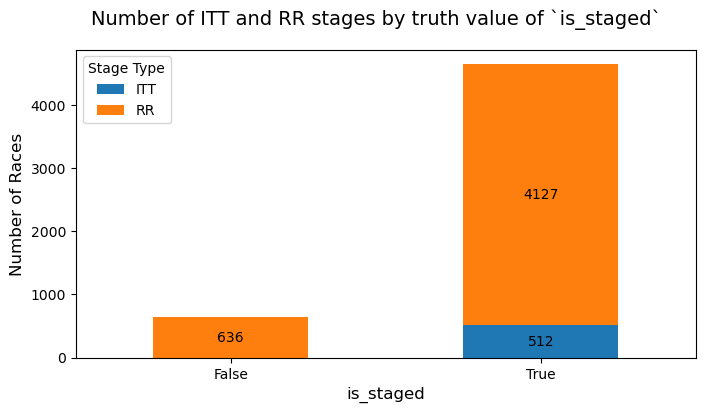

In [27]:
fig, ax = plt.subplots(figsize=(8, 4))
fig.suptitle('Number of ITT and RR stages by truth value of `is_staged`', fontsize=14)

# Get the data
data = races_df.drop_duplicates(subset=['_url']).groupby('is_staged')['stage_type'].value_counts().unstack()

# Plot the data
data.plot(kind='bar', stacked=True, ax=ax)

# Customize the plot
ax.set_ylabel('Number of Races', fontsize=12)
ax.set_xticklabels(['False', 'True'], rotation=0)
ax.set_xlabel('is_staged', fontsize=12)
ax.legend(title='Stage Type', loc='upper left')

# Annotate each bar with the population count
for container in ax.containers:
    # To hide the ugly 0
    labels = [f'{int(v.get_height())}' if v.get_height() > 0 else '' for v in container]
    ax.bar_label(container, labels=labels, label_type='center')

plt.show()

From the plot we can see that only the staged races such as Tour de France have Individual Time Trials. The non-staged races are categorized as Road Races. The ITT stages are really few compared to the "normal" RR stages.

In [28]:
print(f"Overall, in the staged races {(512*100)/4133:5.2f}% of the stages are ITT")

Overall, in the staged races 12.39% of the stages are ITT


The following table shows, for each (staged) competition, how many stages (on average) in total are RR, how many are ITT, and their proportion.

In [29]:
# Calculate non-normalized counts
non_normalized_counts = races_df[races_df['is_staged']].drop_duplicates(subset=['_url']).groupby('name')['stage_type'].value_counts().unstack().fillna(0)

# Calculate normalized counts
normalized_counts = races_df[races_df['is_staged']].drop_duplicates(subset=['_url']).groupby('name')['stage_type'].value_counts(normalize=True).unstack().fillna(0)

# Rename columns
normalized_counts.rename(columns={'RR': 'RR (norm.)', 'ITT': 'ITT (norm.)'}, inplace=True)

# Add the total column from non-normalized counts to normalized counts
normalized_counts['total'] = non_normalized_counts.sum(axis=1)

pd.concat([normalized_counts, non_normalized_counts], axis=1)

stage_type,ITT (norm.),RR (norm.),total,ITT,RR
name,,,,,
Criterium du Dauphiné,0.113475,0.886525,282,32,250
Giro d'Italia,0.103641,0.896359,714,74,640
Gran Camiño,0.285714,0.714286,7,2,5
Itzulia Basque Country,0.166667,0.833333,138,23,115
La Vuelta ciclista a España,0.099664,0.900336,893,89,804
Paris - Nice,0.098985,0.901015,394,39,355
Tirreno-Adriatico,0.114391,0.885609,271,31,240
Tour de France,0.102086,0.897914,911,93,818
Tour de Romandie,0.148760,0.851240,242,36,206


We can see that for all races except the Grand Camino, 10% circa of the races are Individual Time Trials. This is consistent with the 12.39% value gotten earlier.

In particular, the proportion is the same for all staged races. In other words, the distribution of `stage_type` (i.e. of `RR` and `ITT`) is uniform, with respect to the races themselves.


### `length` vs `stage_type`

Thanks to the domain experts (prof. Setzu) we know that a stage can simply be a road race (RR) or can be a individual time trial (ITT) stage. Furthermore:
- All staged races (e.g. Tour de France) have at least one stage that is ITT
- A ITT differs from a RR for the fact that in the latter all cyclists start at the same time all together, while in a ITT the cyclists start cycling one after the other
- Typically ITTs are shorter

Let's try to see how the `stage_type` compares with the `length`

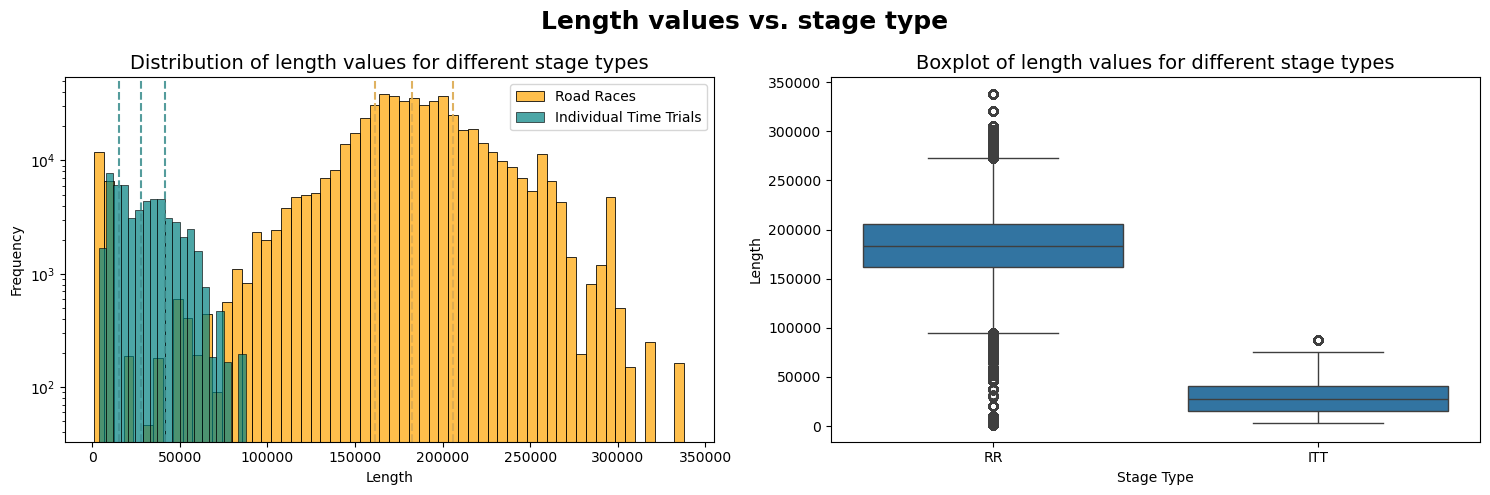

In [30]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
fig.suptitle('Length values vs. stage type', fontsize=18, fontweight='bold')


sns.histplot(races_df.loc[races_df['stage_type'] == 'RR', 'length'], bins=60, kde=False, color='orange', alpha=0.7, label='Road Races', ax=ax[0])
rr_quartiles = races_df.loc[races_df['stage_type'] == 'RR', 'length'].quantile([0.25, 0.5, 0.75])

sns.histplot(races_df.loc[races_df['stage_type'] == 'ITT', 'length'], bins=20, kde=False, color='teal', alpha=0.7, label='Individual Time Trials', ax=ax[0])
itt_quartiles = races_df.loc[races_df['stage_type'] == 'ITT', 'length'].quantile([0.25, 0.5, 0.75])

# Add vertical lines for Road Races quartiles
for q in rr_quartiles:
    ax[0].axvline(q, linestyle='--', color=(220/255,170/255,80/255), alpha=0.9)

# Add vertical lines for Individual Time Trials quartiles
for q in itt_quartiles:
    ax[0].axvline(q, linestyle='--', color=(65/255,145/255,145/255), alpha=0.9)
    
ax[0].set_title('Distribution of length values for different stage types', fontsize=14)
ax[0].set_xlabel('Length')
ax[0].set_ylabel('Frequency')
ax[0].set_yscale('log')
ax[0].legend()

sns.boxplot(data=races_df, x='stage_type', y='length', ax=ax[1])
ax[1].set_title('Boxplot of length values for different stage types', fontsize=14)
ax[1].set_xlabel('Stage Type')
ax[1].set_ylabel('Length')



plt.tight_layout()
plt.show()

As we can see, the two distributions are very well separated visually, but there is some overlap, because there are short road races.

In [31]:
# Not the best... To review... To do better... Maybe with the name_stage feature?
races_df.loc[(races_df['length'] < 100000) & (races_df['stage_type'] == 'RR'), 'name'].unique()

array(['Volta Ciclista a Catalunya', 'La Vuelta ciclista a España',
       'Tour de Romandie', 'Tour de Suisse', 'Paris - Nice',
       "Giro d'Italia", 'Tour de France', 'Tirreno-Adriatico',
       'Criterium du Dauphiné', 'Itzulia Basque Country'], dtype=object)

In [32]:
races_df.groupby('stage_type')['length'].describe()

,count,mean,std,min,25%,50%,75%,max
stage_type,,,,,,,,
ITT,55727.0,29711.932815,16890.524285,3600.0,15100.0,28000.0,41200.0,87500.0
RR,548803.0,180737.177603,49641.541736,1000.0,161500.0,182800.0,206000.0,338000.0


As we can see, `RR` is the majority class. 

The average length of a `ITT` is 29,7 Km, very close to the median, that is 28 Km. <br>
The average length of a `RR` is 180 Km, very close to the median, that is 183 Km.

We can notice that all the mass of the `ITT`'s length distribution is before the first quartile of the `RR`'s length distribution. 

**TODO**: Correlation? O qualcosa di simile? Dovrei studiarlo...

In [33]:
# Qui ci mettiamo la correlazione o qualcosa del genere.

All in all, `length` is an excellent predictor of `stage_type`, but not a perfect one. It's ok to have the ground truth.

### `startlist_quality` vs `stage_type`

We can see if other bimodal distributions are "caused" by the `stage_type`, let's analize the `startlist_quality` in the same way

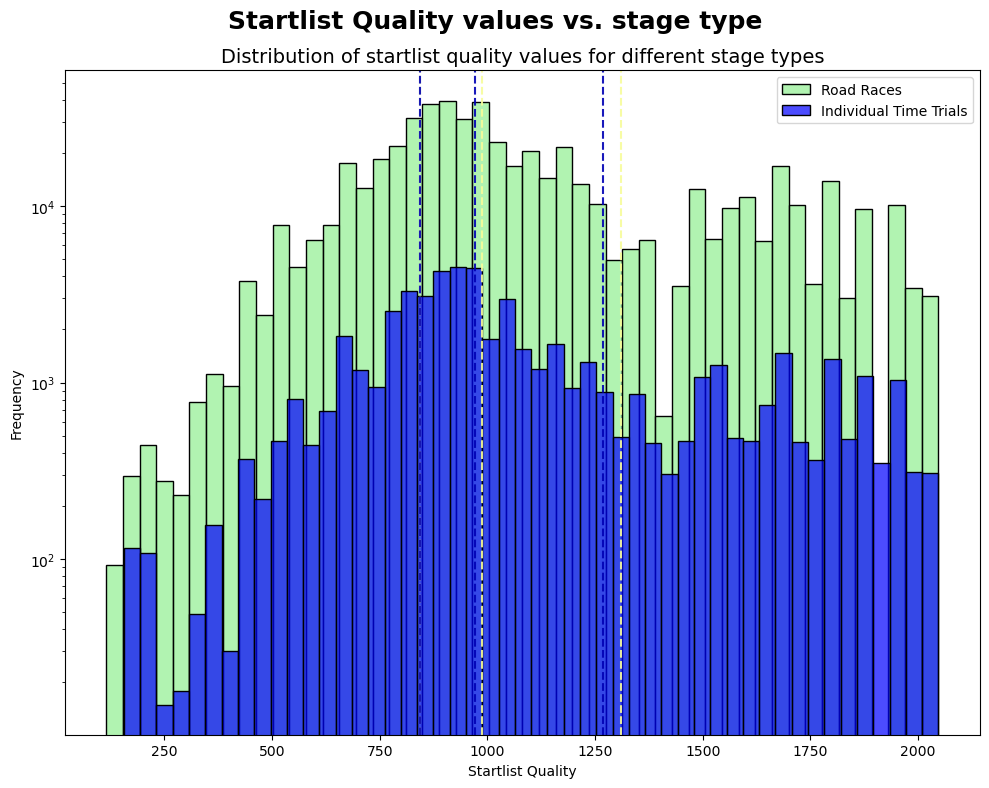

In [34]:
fig, ax = plt.subplots(figsize=(10,8))
fig.suptitle('Startlist Quality values vs. stage type', fontsize=18, fontweight='bold')

sns.histplot(races_df.loc[races_df['stage_type'] == 'RR', 'startlist_quality'], bins=50, kde=False, color='lightgreen', alpha=0.7, label='Road Races', ax=ax)
rr_quartiles = races_df.loc[races_df['stage_type'] == 'RR', 'startlist_quality'].quantile([0.25, 0.5, 0.75])

sns.histplot(races_df.loc[races_df['stage_type'] == 'ITT', 'startlist_quality'], bins=50, kde=False, color='blue', alpha=0.7, label='Individual Time Trials', ax=ax)
itt_quartiles = races_df.loc[races_df['stage_type'] == 'ITT', 'startlist_quality'].quantile([0.25, 0.5, 0.75])

# Add vertical lines for Road Races quartiles
for q in rr_quartiles:
    ax.axvline(q, linestyle='--', color=(247/255,252/255,154/255), alpha=0.9)#I'm not gonna lie, I'm not gonna search for the right color

# Add vertical lines for Individual Time Trials quartiles
for q in itt_quartiles:
    ax.axvline(q, linestyle='--', color=(0/255,0/255,180/255), alpha=0.9)
    
ax.set_title('Distribution of startlist quality values for different stage types', fontsize=14)
ax.set_xlabel('Startlist Quality')
ax.set_ylabel('Frequency')
ax.set_yscale('log')
ax.legend()

plt.tight_layout()
plt.show()

This is the opposite of what I was expecting but is indeed intresting to see that the distributions have almost the same shape, this could suggest that the people racing are the same.

***Andrea***: *I think that it's reasonable that the two frequencies follow the same patterns, the `RR` one being a "dilated" version of the `ITT` one, because basically in all the staged races there's one stage that is an ITT and more or less will have the same participants of all the other stages (therefore the same `startlist_quality`). Most of the competitions are staged (we should assess that...), the non-staged ones "add a little bit of noise to this process", but could look more into detail if so wishes. But maybe you had a different idea.*

We think that the road races that are short can be prologue of stage races. We suppose this after we've seen that the shortest race is a prologue. If this is true we could say that the distribution of non prologue RR is more or less Normal

### A deeper study of `length`

First of all we need to create a column that tells us the stage name near the name, s.t. we don't need to retrieve the information from the `_url` each time

In [35]:
def get_name_stage(row) -> Tuple[str, str]:
    array_of_info = row['_url'].split('/')
    array_of_info[-1] = np.nan if array_of_info[-1] == 'result' else array_of_info[-1]
    return array_of_info[0], array_of_info[-1]

#define column name
races_df['stage'] = races_df.apply(lambda row: get_name_stage(row)[1], axis=1)
# move name column to the second position
cols = list(races_df.columns)
cols.insert(2, cols.pop(cols.index('stage')))
races_df = races_df[cols]

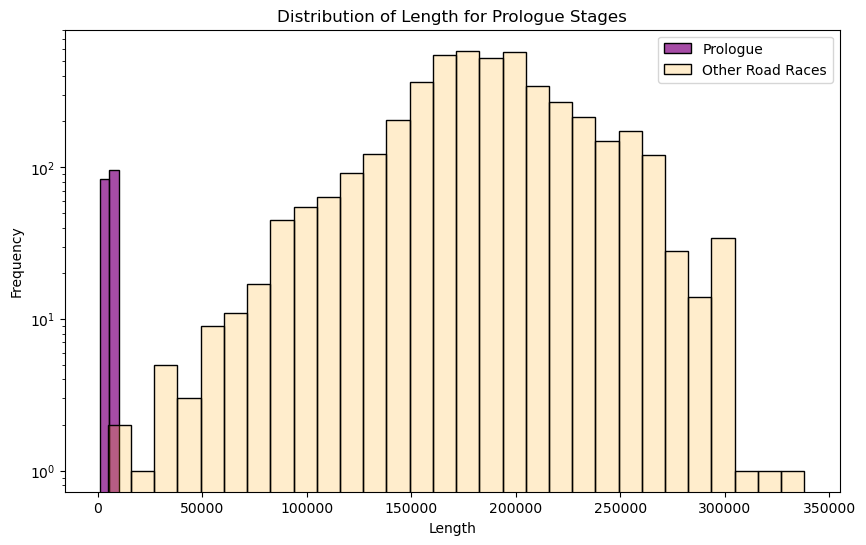

In [36]:
prologue_races = races_df.drop_duplicates(subset=['_url'])
other_rr = prologue_races[(prologue_races['stage_type'] == 'RR') & (prologue_races['stage'] != 'prologue')]
prologue_races = prologue_races[prologue_races['stage'] == 'prologue']

plt.figure(figsize=(10, 6))
sns.histplot(prologue_races['length'], bins=2, kde=False, color='purple', alpha=0.7)
sns.histplot(other_rr['length'], bins=30, kde=False, color='orange', alpha=0.2)
plt.title('Distribution of Length for Prologue Stages')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.yscale('log')
plt.legend(['Prologue', 'Other Road Races'])
plt.show()

We can discuss about the color palette of this plot, and the way it is obtained, but for sure we can say that prologues are the short road races. To see this even better, let's control the distribution of just the prologue length since now it is all compressed to the left.

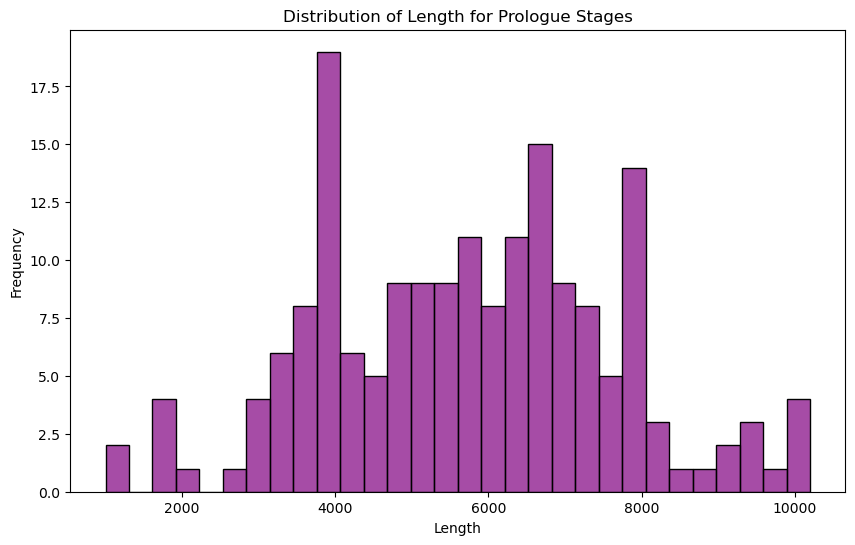

In [37]:
races_df_ = races_df.drop_duplicates(subset=['_url'])
# Filter the races where the stage is a prologue
prologue_races = races_df_[races_df_['stage'] == 'prologue']

# Plot the length of these races
plt.figure(figsize=(10, 6))
sns.histplot(prologue_races['length'], bins=30, kde=False, color='purple', alpha=0.7)
plt.title('Distribution of Length for Prologue Stages')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()

In [38]:
print('There are:', prologue_races[prologue_races['stage_type'] == 'RR'].shape[0], "RR")
print("      and:", prologue_races[prologue_races['stage_type'] == 'ITT'].shape[0],"ITT")

There are: 178 RR
      and: 1 ITT


Nice, we discovered that the shape of the overall shape of the length distribution was given by the summation of 3 different "almost gaussian distribution". We can also see that one prologue only was an ITT race, and there are not many analysis we can do on a single value...

##### Is it normal, though?

We've gone a long way in analyzing the `length` values. The initial distribution $\mathbb{P}(\mathtt{length})$ didn't look nice, but then we noticed that by looking at the `stage_type` the distributions $\mathbb{P}(\mathtt{length},\mathtt{stage\_type}=\mathtt{RR})$ and $\mathbb{P}(\mathtt{length},\mathtt{stage\_type}=\mathtt{ITT})$ are well separated.

$$\begin{align*} 
    \mathbb{P}(\mathtt{length})&=\sum_{s\in\{\mathtt{RR},\mathtt{ITT}\}}\mathbb{P}(\mathtt{length},\mathtt{stage\_type}=\mathtt{s})\\
    &= \mathbb{P}(\mathtt{length},\mathtt{stage\_type}=\mathtt{RR})+\mathbb{P}(\mathtt{length},\mathtt{stage\_type}=\mathtt{ITT})
\end{align*}
$$

But we saw that the distribution of the `RR` stages' length had many small values, and discovered that it was the "fault" of the `prologue` stages. The `prologue` stages are significantly shorter than the non-`prologue` ones, and almost all the `prologue` stages are `RR` stages, we'll just ignore the only `ITT` and `prologue` stage.

By isolating the `prologue` stages, we noticed that the `length` distribution was even nicer. Therefore we claim that the "proper" vay to interpret the distribution of the length values is the following:

$$ \mathbb{P}(\mathtt{length}) = \mathbb{P}\left(\mathtt{length},\mathtt{stage\_type}=\mathtt{ITT}\right)+\mathbb{P}\left(\mathtt{length},\neg\,\mathtt{prologue}\right) +\mathbb{P}(\mathtt{length},\mathtt{prologue})$$

(we didn't mention the $\mathtt{stage\_type}=\mathtt{RR}$ when `prologue` was mentioned, to remove redundancies).

We said that the distribution of the non-prologue stages' length is almost normal. Is it normal, though?

Well, it's time for statistical hypothesis testing!

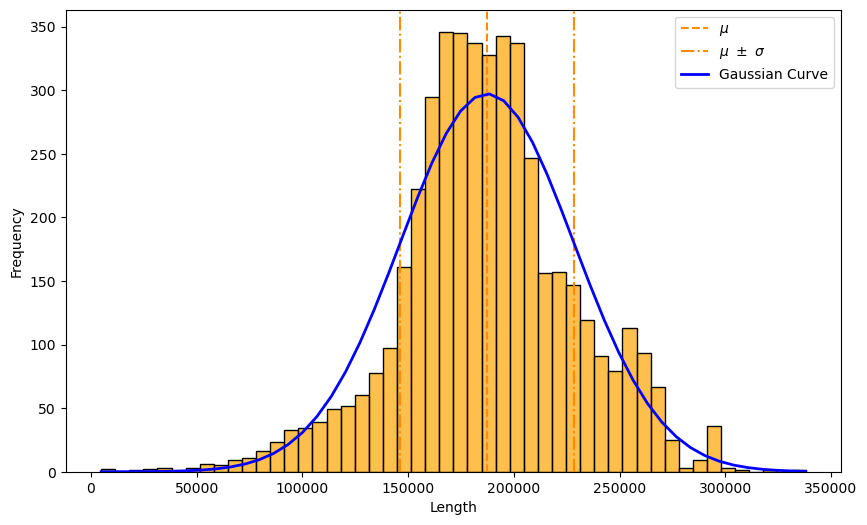

In [39]:
from scipy.stats import norm

plt.figure(figsize=(10, 6))

non_prologue_length_values = other_rr['length']#.values
mean = non_prologue_length_values.mean()
std = non_prologue_length_values.std()

n_bins = 50

sns.histplot(non_prologue_length_values, bins=n_bins, kde=False, color='orange', alpha=0.7)
plt.axvline(mean, color='darkorange', linestyle='--', label=r'$\mu$')
plt.axvline(mean + std, color='darkorange', linestyle='-.', label=r'$\mu\ \pm\ \sigma$')
plt.axvline(mean - std, color='darkorange', linestyle='-.')

# Generate x values, for the Gaussian curve
x = np.linspace(non_prologue_length_values.min(), non_prologue_length_values.max(), n_bins)#, non_prologue_length_values.shape[0])

# Generate y values for the Gaussian curve
y = norm.pdf(x, mean, std) * len(non_prologue_length_values) * (non_prologue_length_values.max() - non_prologue_length_values.min()) / n_bins  # Adjusting for histogram scaling

# Plot the Gaussian curve
plt.plot(x, y, color='blue', linestyle='-', linewidth=2, label='Gaussian Curve')

plt.xlabel('Length')
plt.ylabel('Frequency')
#plt.yscale('log')
plt.legend()
plt.show()

We now conduct a $\chi^2$ test on `non_prologue_length_values` with expected frequencies given by a normal random variable with law $\mathcal{N}(\mu,\sigma^2)$, where $\mu$ and $\sigma$ are (respectively) the mean and standard deviation of `non_prologue_length_values`.

An important observation is that the binning has a crucial impact on the outcome of the test. 

In [40]:
import scipy.stats as stats

# Get the observed frequencies, grouping them in n_bins evenly spaced bins
observed_freq, bin_edges = np.histogram(non_prologue_length_values, bins=n_bins)

# Calculate the expected frequencies using the cumulative distribution function of our Gaussian
expected_freq = len(non_prologue_length_values) * np.diff(stats.norm.cdf(bin_edges, mean, std))

# Normalize the expected frequencies to match the sum of the observed frequencies
expected_freq *= observed_freq.sum() / expected_freq.sum()

chi2_stat, p_value = stats.chisquare(f_obs=observed_freq, f_exp=expected_freq)

print(f"Chi-squared Statistic: {chi2_stat}")
print(f"P-value: {p_value}")

# Interpretation
# We fix alpha, the power of the test, to be 0.05
alpha = 0.05
if p_value > alpha:
    print("Fail to reject the null hypothesis: The data is approximately normally distributed.")
else:
    print("Reject the null hypothesis: The data is not approximately normally distributed.")


Chi-squared Statistic: 650.985062932379
P-value: 4.141897057120087e-106
Reject the null hypothesis: The data is not approximately normally distributed.


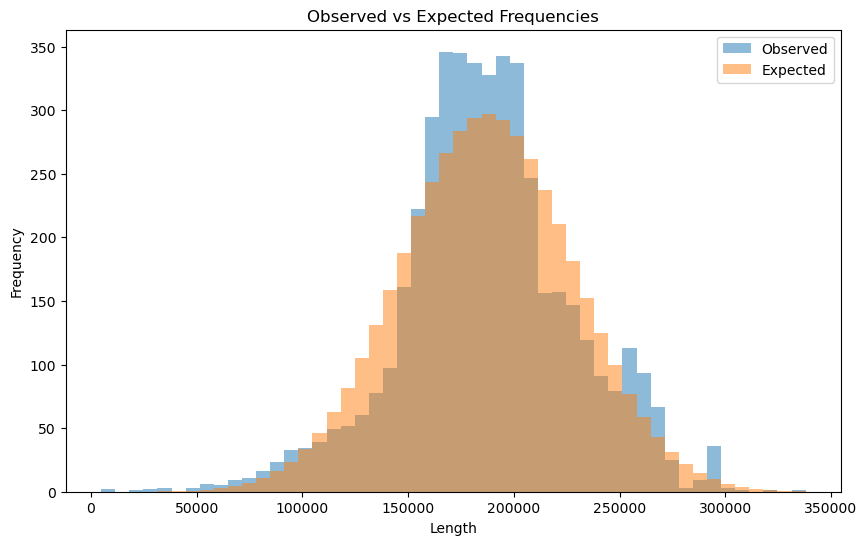

In [41]:
plt.figure(figsize=(10, 6))
plt.hist(bin_edges[:-1], bin_edges, weights=observed_freq, alpha=0.5, label='Observed')
plt.hist(bin_edges[:-1], bin_edges, weights=expected_freq, alpha=0.5, label='Expected')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.title('Observed vs Expected Frequencies')
plt.show()

Well, we can't conclude that the values of length follow a normal distribution, but it was worth trying.

### Top Cyclist

Up to now there is no way of knowing which cyclist is the best, and probably also at the end of the project we will not be able to say who's the best... But at least we can try to give an estimate based on who has accumulated more points (considering only the races in our dataset)

In [42]:
# Group by cyclist and sum the points
points_per_cyclist = races_df.groupby('cyclist')['points'].sum().reset_index()

# Rename the columns for clarity
points_per_cyclist.columns = ['name', 'total_points']

# Merge the points data with the cyclist_df
cyclist_df = cyclist_df.merge(points_per_cyclist, left_on='_url', right_on='name', how='left')
cyclist_df = cyclist_df.drop(columns=['name_y'])
cyclist_df = cyclist_df.rename(columns={'name_x': 'name'})

# Fill NaN values with 0 (for cyclists who have no points in the races_df)
cyclist_df['total_points'] = cyclist_df['total_points'].fillna(0)

cyclist_df.head()

,_url,name,birth_year,weight,height,nationality,bmi,race_count,experience_level,total_points
0,bruno-surra,Bruno Surra,1964.0,NaN,NaN,Italy,NaN,1.0,beginner,0.0
1,gerard-rue,Gérard Rué,1965.0,74.0,182.0,France,22.340297,222.0,pro,1354.0
2,jan-maas,Jan Maas,1996.0,69.0,189.0,Netherlands,19.316369,49.0,developing,60.0
3,nathan-van-hooydonck,Nathan Van Hooydonck,1995.0,78.0,192.0,Belgium,21.158854,164.0,semi-pro,300.0
4,jose-felix-parra,José Félix Parra,1997.0,55.0,171.0,Spain,18.809206,50.0,competitive,5.0


### Study of the inferred features

Some features were inferred from linear combinations of previously existing features. Let's check them out.

Starting from the cyclists' dataset, we aim for the insights that the bmi of the different cyclists can offer

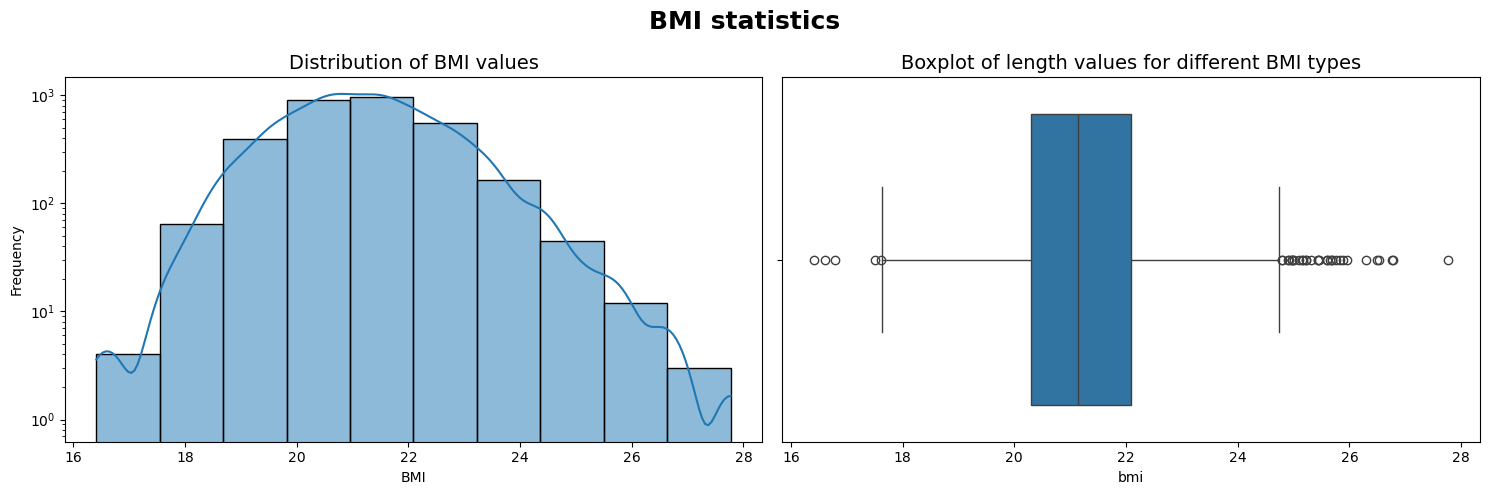

In [43]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
fig.suptitle('BMI statistics', fontsize=18, fontweight='bold')
sns.histplot(cyclist_df['bmi'], bins=10, kde=True, ax=ax[0])
ax[0].set_xlabel('BMI')
ax[0].set_ylabel('Frequency')
ax[0].set_yscale('log')
ax[0].set_title('Distribution of BMI values', fontsize=14)

sns.boxplot(data=cyclist_df, x='bmi', ax=ax[1])
ax[1].set_title('Boxplot of length values for different BMI types', fontsize=14)
ax[1].set_xlabel('bmi')



plt.tight_layout()
plt.show()

Looks like the mean bmi stands a bit below the European average. Some outliers appear, with particular frequency on the "bulkier" side. Cycling is a lot of cardiovascular work and athletes need to balance a good muscular density whilist not weighing too much.

In [44]:
# for the next plot we need a joined dataframe

merged_df = cyclist_df.merge(races_df, left_on='_url', right_on='cyclist', how='inner')

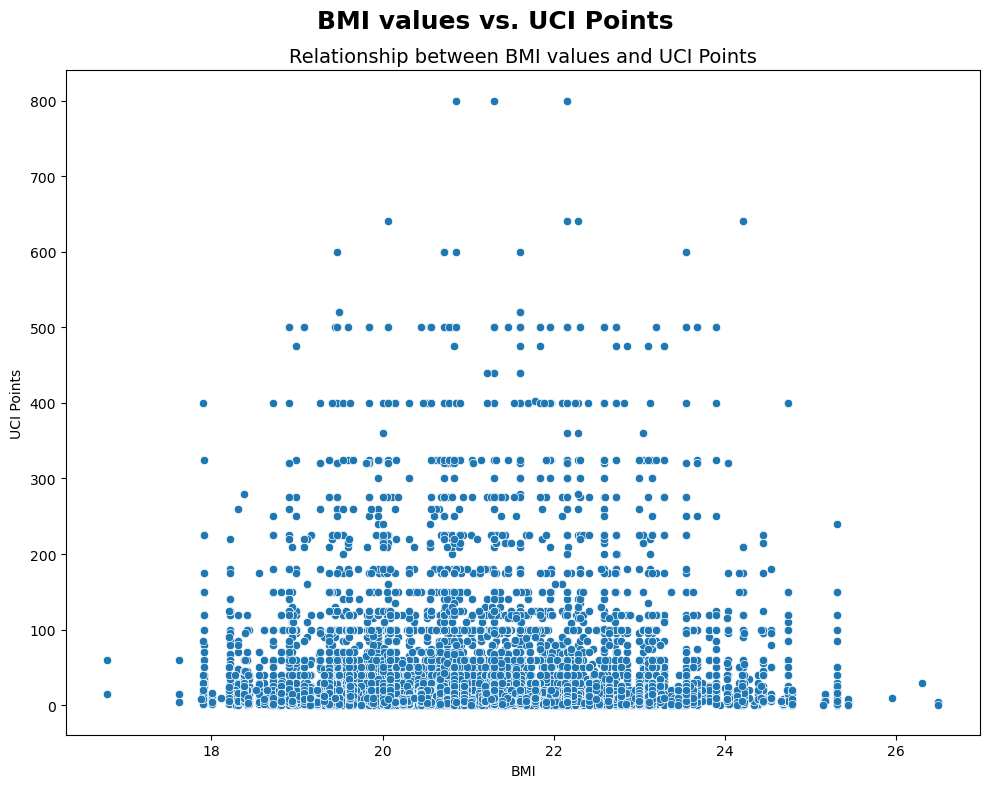

In [45]:
# Analyze the relationship between cyclist_df.bmi and races_df.uci_points.

fig, ax = plt.subplots(figsize=(10,8))
fig.suptitle('BMI values vs. UCI Points', fontsize=18, fontweight='bold')

sns.scatterplot(data=merged_df, x='bmi', y='uci_points', ax=ax)
ax.set_title('Relationship between BMI values and UCI Points', fontsize=14)
ax.set_xlabel('BMI')
ax.set_ylabel('UCI Points')

plt.tight_layout()

Just a random scatterplot doesn't give much information

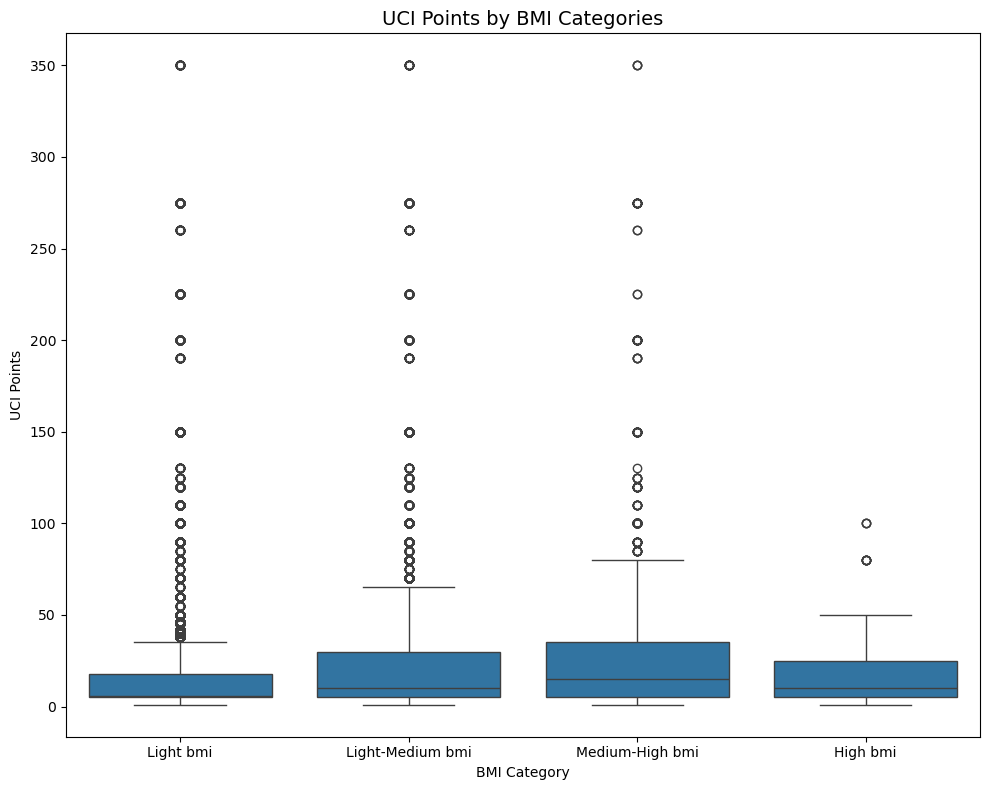

In [46]:
merged_df['bmi_bin'] = pd.cut(merged_df['bmi'], bins=[19, 22, 24, 26, 28], 
                              labels=['Light bmi', 'Light-Medium bmi', 'Medium-High bmi', 'High bmi'])

# Box plot
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=merged_df, x='bmi_bin', y='points', ax=ax)
ax.set_title('UCI Points by BMI Categories', fontsize=14)
ax.set_xlabel('BMI Category')
ax.set_ylabel('UCI Points')
plt.tight_layout()
plt.show()


Most BMIs seem to have a good base of riders who sit under the 70 `uci_points`. What is most interesting from this initial exploration is that there are no cyclists with an high bmi that manage to reach high values for the `uci_points`.
An interesting clustering could be based on these values and the length/steepness/stamina_index of the race, so that we may detect riders that are good on flat terrains, climbers, sprinters, etc...

Now, what insights might we gain from the `experience_level` of a cyclist?

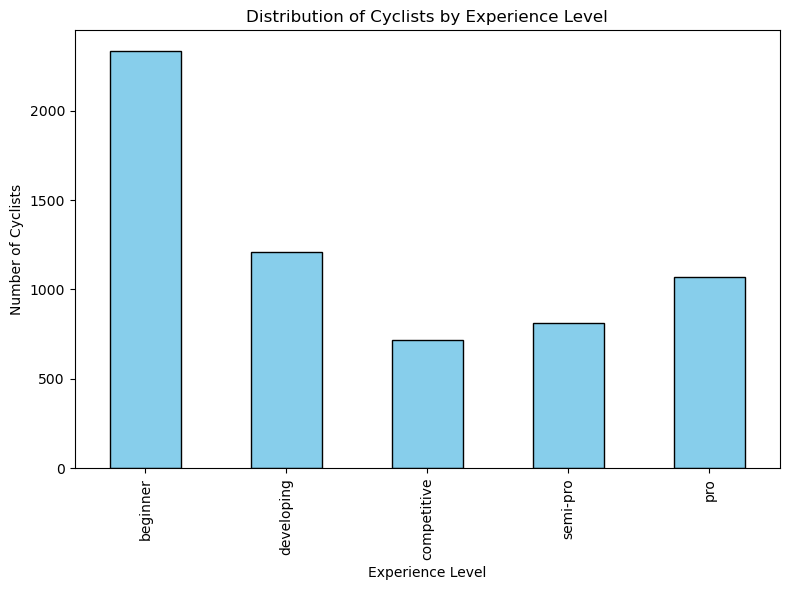

In [47]:
fig, ax = plt.subplots(figsize=(8, 6))
cyclist_df['experience_level'].value_counts().sort_index().plot(kind='bar', ax=ax, color='skyblue', edgecolor='black')
ax.set_title('Distribution of Cyclists by Experience Level')
ax.set_xlabel('Experience Level')
ax.set_ylabel('Number of Cyclists')
plt.tight_layout()
plt.show()


The distribution is quite skewed towards beginners. Also, seems that pro cyclists are more represented in the dataset than semi-pro and competitives. We expected the density to decrease monotonically. How do they distribute with respect to the age? 

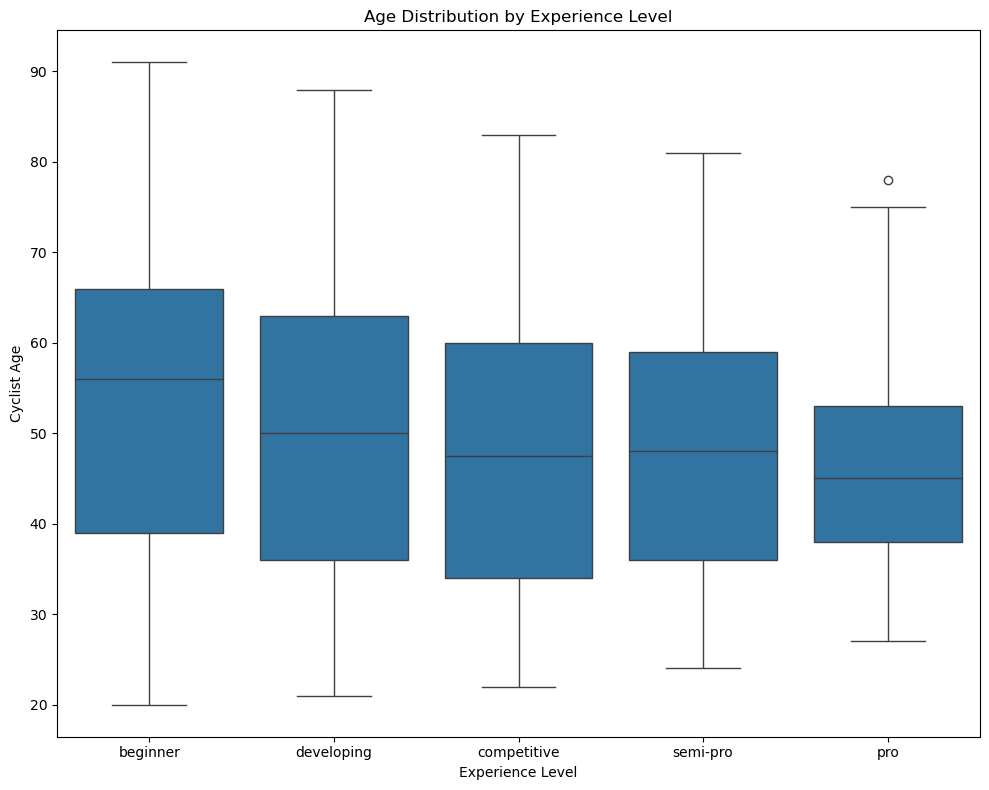

In [48]:
import datetime
current_year = datetime.datetime.now().year
cyclist_df['cyclist_age'] = current_year - cyclist_df['birth_year']

fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=cyclist_df, x='experience_level', y='cyclist_age', ax=ax)
ax.set_title('Age Distribution by Experience Level')
ax.set_xlabel('Experience Level')
ax.set_ylabel('Cyclist Age')
plt.tight_layout()
plt.show()

Considering the fact that there are a lot of cyclists that ran in *ancient* races, we expected a lot more cyclists to be considered methusalems! Also, we can see that pro level cyclists tend to sit into a narrower distribution. 

In [51]:
# Step 2: Merge total points with cyclist_df
# cyclist_df = cyclist_df.merge(points_agg, left_on='_url', right_on='cyclist', how='left')
cyclist_df['total_points'] = cyclist_df['total_points'].fillna(0)

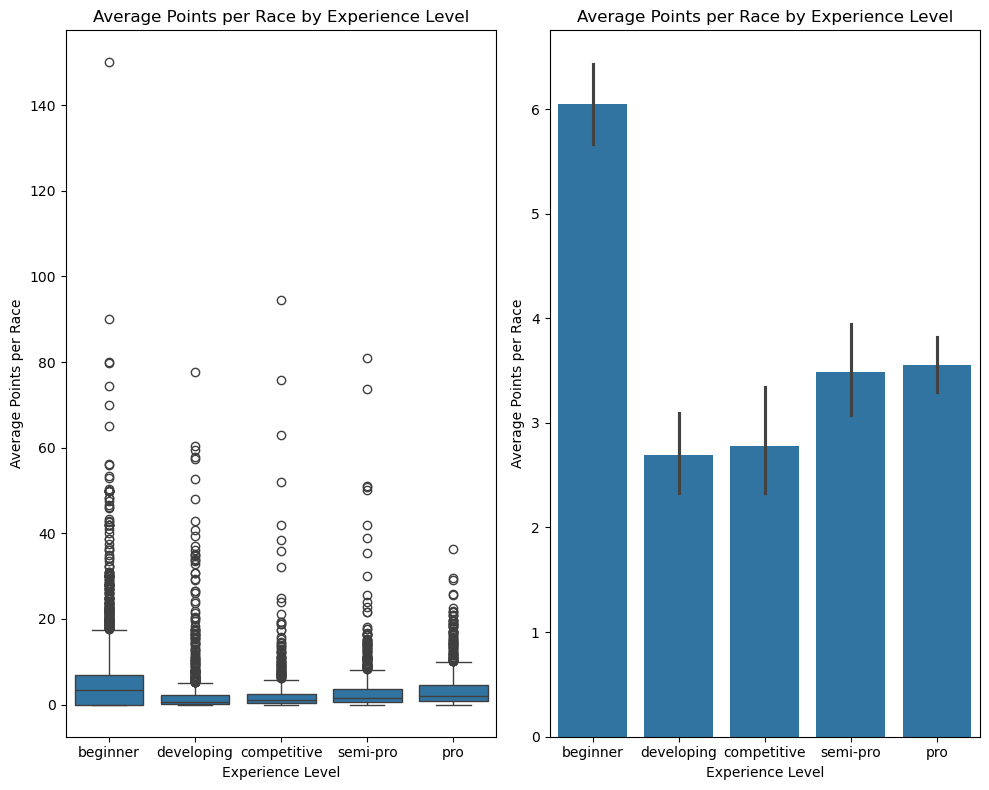

In [52]:
# Step 3: Calculate average points per race
cyclist_df['avg_points_per_race'] = cyclist_df['total_points'] / cyclist_df['race_count']
cyclist_df['avg_points_per_race'] = cyclist_df['avg_points_per_race'].fillna(0)


fig, ax = plt.subplots(1, 2, figsize=(10, 8))
sns.boxplot(data=cyclist_df, x='experience_level', y='avg_points_per_race', ax=ax[0])
ax[0].set_title('Average Points per Race by Experience Level')
ax[0].set_xlabel('Experience Level')
ax[0].set_ylabel('Average Points per Race')

# sns.stripplot(data = cyclist_df, x='experience_level', y= 'avg_points_per_race', ax=ax[1])
sns.barplot(data=cyclist_df, x='experience_level', y='avg_points_per_race', ax=ax[1])
ax[1].set_title('Average Points per Race by Experience Level')
ax[1].set_xlabel('Experience Level')
ax[1].set_ylabel('Average Points per Race')
plt.tight_layout()
plt.show()

The distributions of average points for the different experience level reveal some insight: beginners have higher values, while from developing to pros we can see a monotonical growth. What we believe is that beginners seem exceptional because, with less races ran, exceptional performances on certain tracks are valued more. Rising stars or people whose craft hasn't been truly tested? Only future will tell. Or maybe it's the zeros.

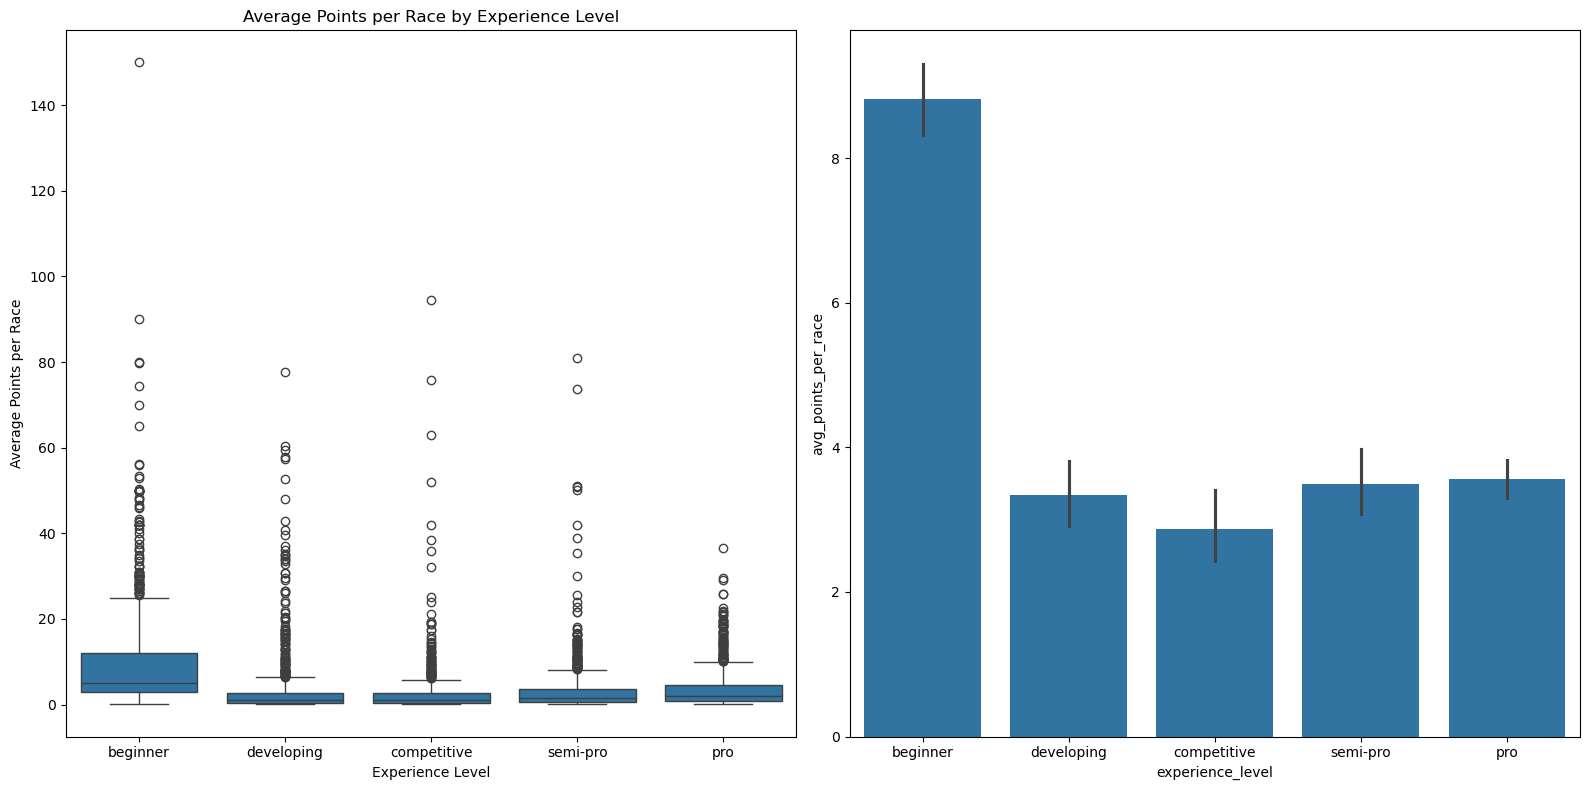

In [53]:
filtered_df = cyclist_df[cyclist_df['avg_points_per_race'] > 0]

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
sns.boxplot(data=filtered_df, x='experience_level', y='avg_points_per_race', ax=ax[0])
ax[0].set_title('Average Points per Race by Experience Level')
ax[0].set_xlabel('Experience Level')
ax[0].set_ylabel('Average Points per Race')

sns.barplot(data=filtered_df, x='experience_level', y='avg_points_per_race', ax=ax[1])
ax[0].set_title('Average Points per Race by Experience Level')
ax[0].set_xlabel('Experience Level')
ax[0].set_ylabel('Average Points per Race')

plt.tight_layout()
plt.show()


It's quite not the zeros.

Let's check the distribution of `race_country`.

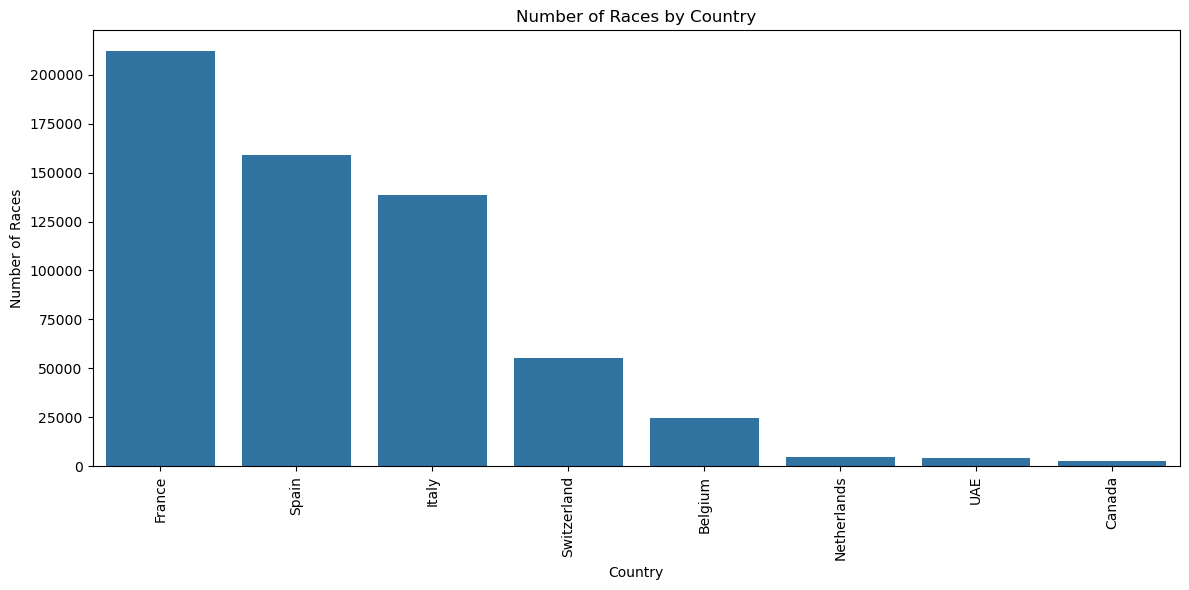

In [54]:
# count the different values for races_df['race_country']

plt.figure(figsize=(12, 6))
sns.countplot(x='race_country', data=races_df, order=races_df['race_country'].value_counts().index)
plt.xticks(rotation=90)
plt.title('Number of Races by Country')
plt.xlabel('Country')
plt.ylabel('Number of Races')
plt.tight_layout()
plt.show()

Well, seems that Europe has quite some hegemony over cyclism. How are they distributed over seasons?

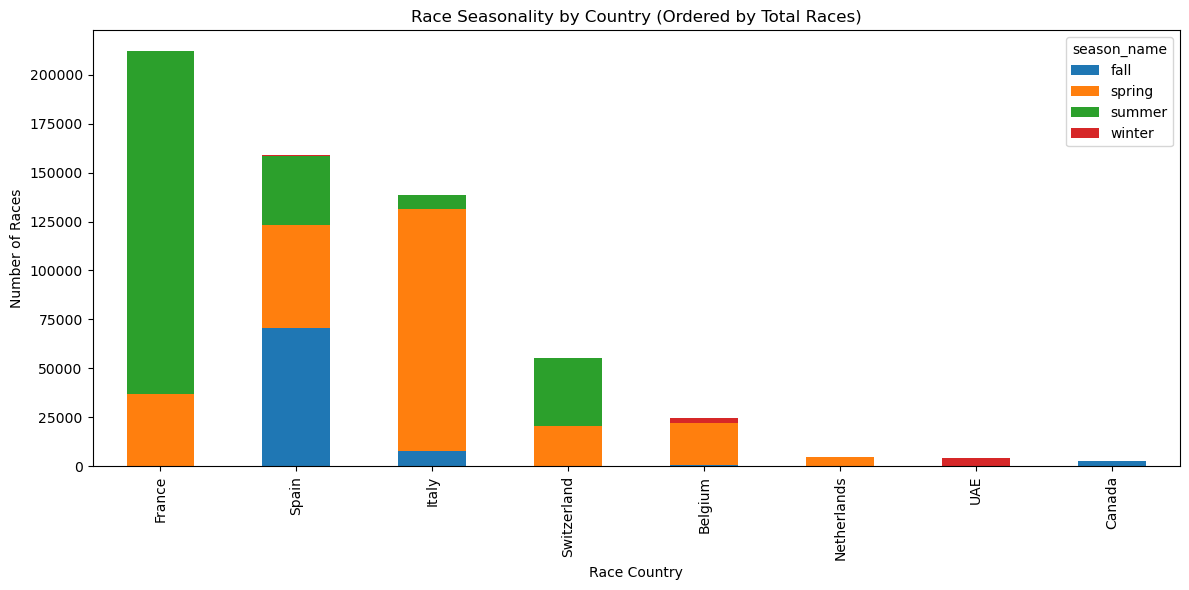

In [55]:
season_map = {0: 'winter', 1: 'spring', 2: 'summer', 3: 'fall'}

# Apply the mapping to the 'season' column
races_df['season_name'] = races_df['season'].map(season_map)

# Group by race_country and season_name, then count occurrences
race_seasonality = races_df.groupby(['race_country', 'season_name']).size().unstack().fillna(0)

# order by totale races
country_total_races = race_seasonality.sum(axis=1)
sorted_countries = country_total_races.sort_values(ascending=False).index
race_seasonality = race_seasonality.loc[sorted_countries]

race_seasonality.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Race Seasonality by Country (Ordered by Total Races)')
plt.xlabel('Race Country')
plt.ylabel('Number of Races')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Now, onto speed!

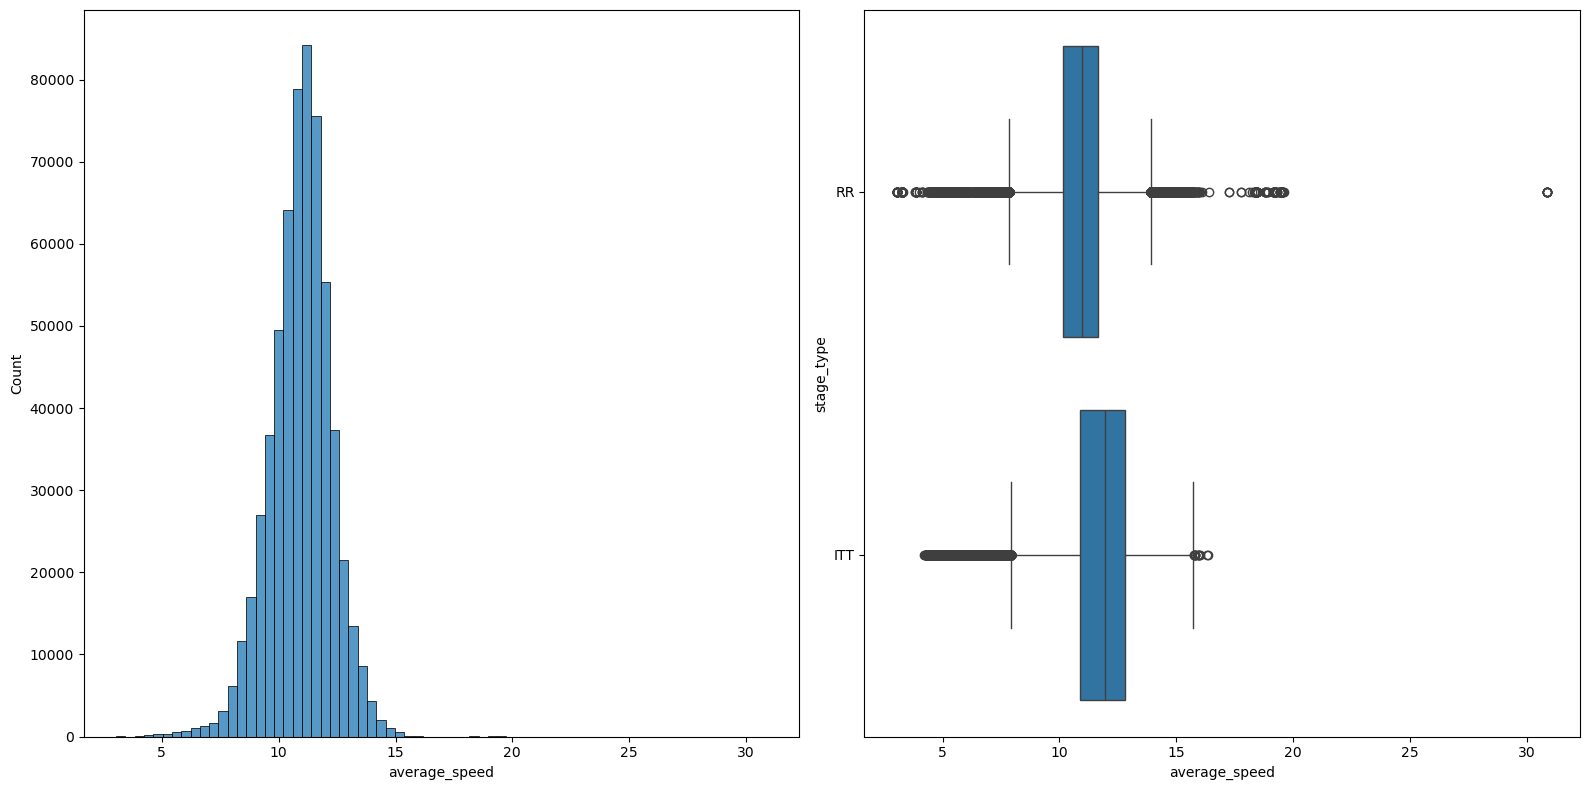

In [56]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
sns.histplot(races_df['average_speed'], bins=70, ax=ax[0])
sns.boxplot(data=races_df, x='average_speed', y=races_df['stage_type'], ax=ax[1])

plt.tight_layout()
plt.show()

Ghost riders aside, it seems that people tend to move faster during individual time tracks. Also, our distribution more or less resembles a normal one.
Let's check the average speed for each cyclist

In [57]:
# Step 2: Compute average speed for each cyclist
cyclist_avg_speed = races_df.groupby('cyclist')['average_speed'].mean().reset_index()

# Step 3: Rename the column for clarity
cyclist_avg_speed.rename(columns={'average_speed': 'avg_speed_cyclist', 'cyclist': '_url'}, inplace=True)

# Step 4: Merge with cyclist_df if needed
cyclist_df = cyclist_df.merge(cyclist_avg_speed, how='left', on='_url')

cyclist_df['avg_speed_cyclist'].describe()

count    6093.000000
mean       10.888745
std         0.491717
min         5.349183
25%        10.660867
50%        10.915681
75%        11.122065
max        16.695447
Name: avg_speed_cyclist, dtype: float64

And now we plot it

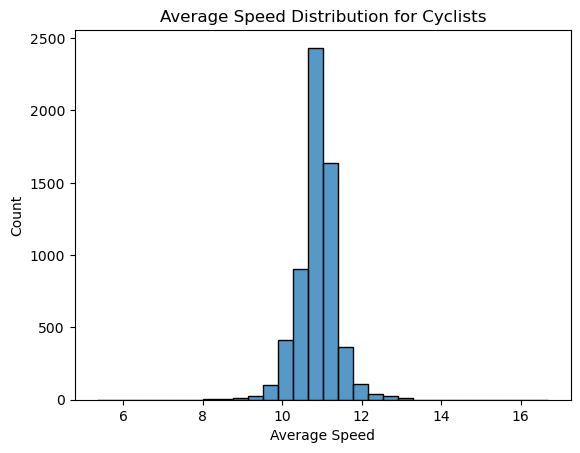

In [58]:
sns.histplot(cyclist_df['avg_speed_cyclist'], bins=30)

# sns.violinplot(data=cyclist_df, x='avg_speed_cyclist')
plt.title('Average Speed Distribution for Cyclists')
plt.xlabel('Average Speed')

plt.show()


Let's study it in relationship with other features

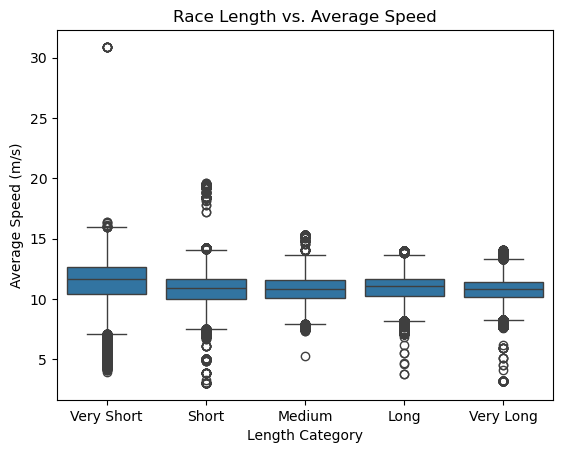

In [59]:
# Create quantile-based bins
races_df['length_category'] = pd.qcut(races_df['length'], q=5, labels=['Very Short', 'Short', 'Medium', 'Long', 'Very Long'])

# sns.scatterplot(data=races_df, x='length', y='average_speed')
sns.boxplot(data=races_df, x='length_category', y='average_speed')
plt.title('Race Length vs. Average Speed')
plt.xlabel('Length Category')
plt.ylabel('Average Speed (m/s)')
plt.show()

As we can see, shorter races have the highest average speeds.

Do athletes with higher bmi have less speed on average?

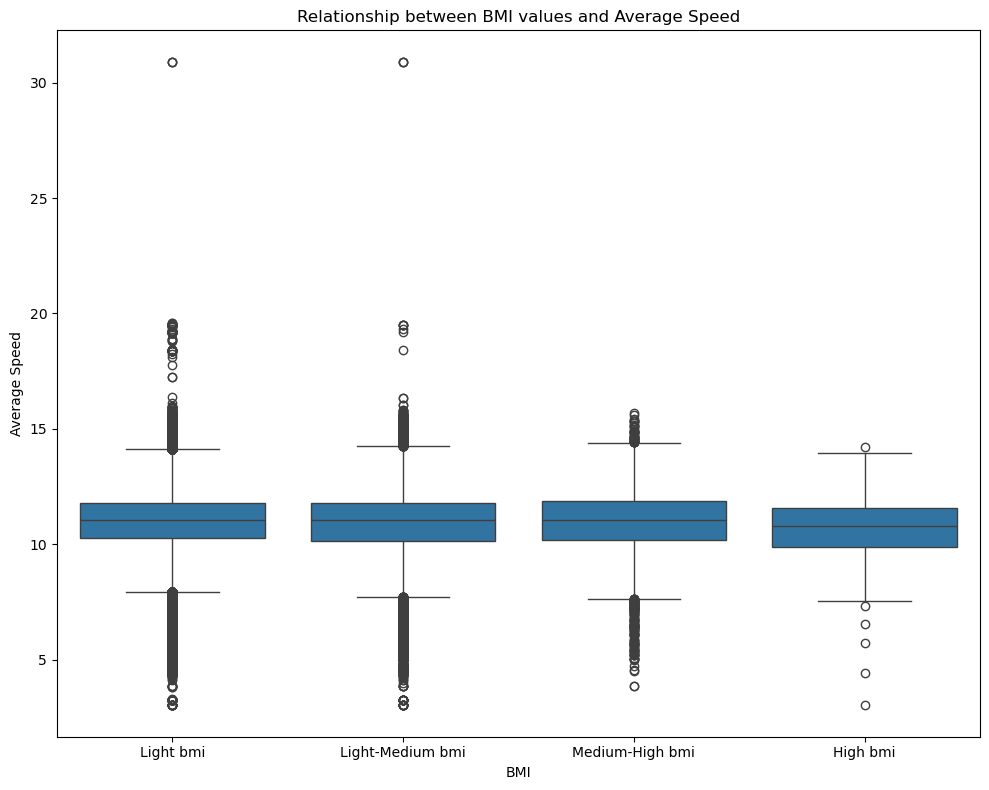

In [60]:
merged_df = merged_df[merged_df['average_speed'] < 40]
# compare bmi and speed

fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=merged_df, x='bmi_bin', y='average_speed', ax=ax)
ax.set_title('Relationship between BMI values and Average Speed')
ax.set_xlabel('BMI')
ax.set_ylabel('Average Speed')

plt.tight_layout()
plt.show()


Kinda!

Now, let's move onto the `steepness` of the races. We try to confront them with the acquired points. Maybe, steeper tracks may provide more points (if the race is more difficult it's reasonable if it's valued more) or less points (being more difficult, the performance of the cyclists is scarcer). We try to check this with a scatterplot, coloring the points based on the `stage_type` to see if we can gain any insight from this analysis.

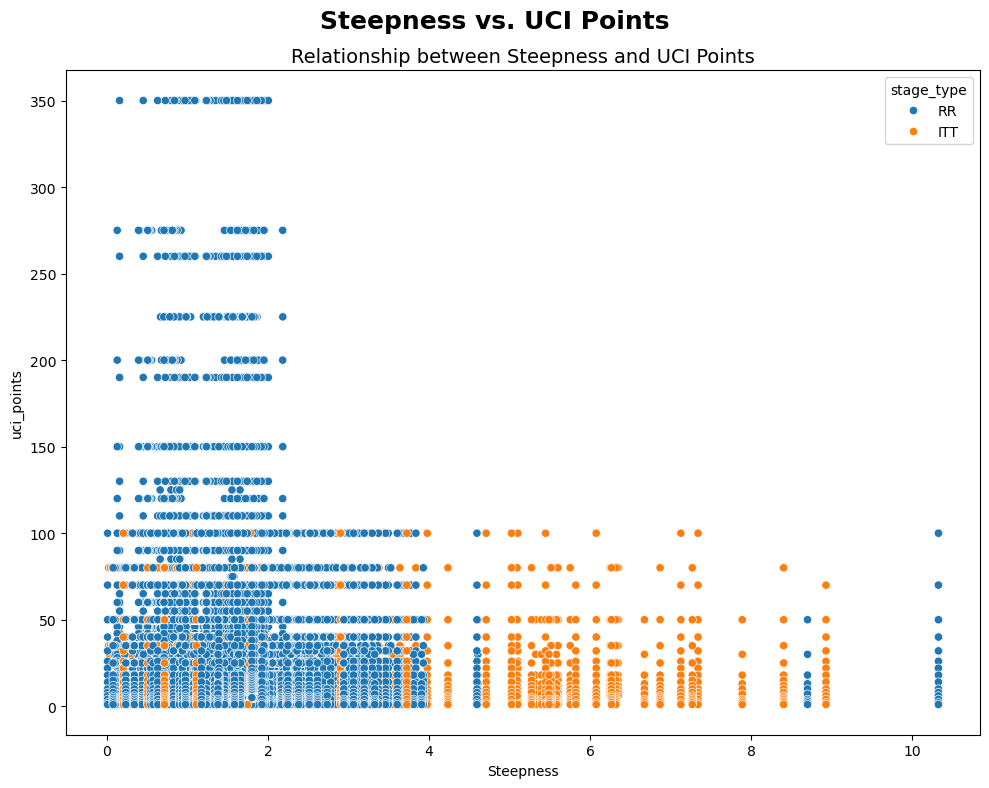

In [61]:
# Analyze the relationship between cyclist_df.bmi and races_df.uci_points.

fig, ax = plt.subplots(figsize=(10,8))
fig.suptitle('Steepness vs. UCI Points', fontsize=18, fontweight='bold')

sns.scatterplot(data=races_df, x='steepness', y='points', hue='stage_type')
ax.set_title('Relationship between Steepness and UCI Points', fontsize=14)
ax.set_xlabel('Steepness')
ax.set_ylabel('uci_points')

plt.tight_layout()

As we can see, a wider context gives a more comprehensive breadth of analysis. We can see two main things from this plot:
1. Flatter tracks open the possibility to gain a great amount of points.
2. Most Individual Time Trials are ran on medium to high steepness levels. This is probably due to the fact that being them organized on shorter races, the steep sections contribute more to the steepness value of the race.

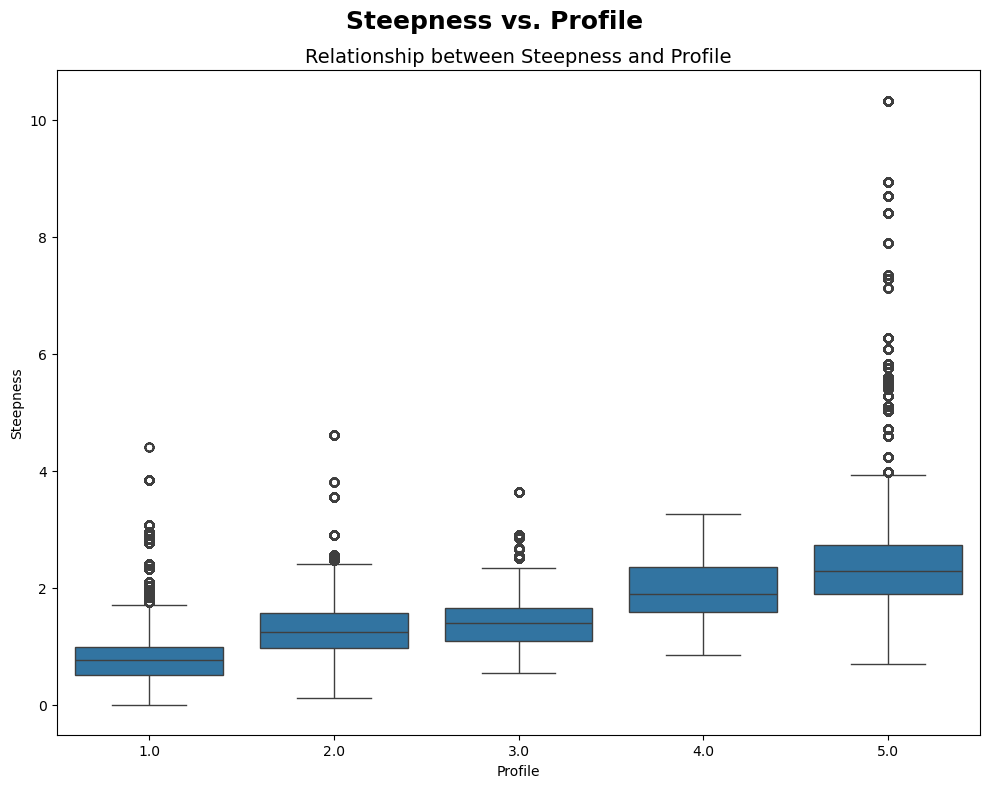

In [62]:
fig, ax = plt.subplots(figsize=(10,8))
fig.suptitle('Steepness vs. Profile', fontsize=18, fontweight='bold')

sns.boxplot(data=races_df, x='profile', y='steepness', ax=ax)

ax.set_title('Relationship between Steepness and Profile', fontsize=14)
ax.set_xlabel('Profile')
ax.set_ylabel('Steepness')

plt.tight_layout()

As we can see, only the highest steepness values fit into the highest race profiles. Let's check how it influences the average speed

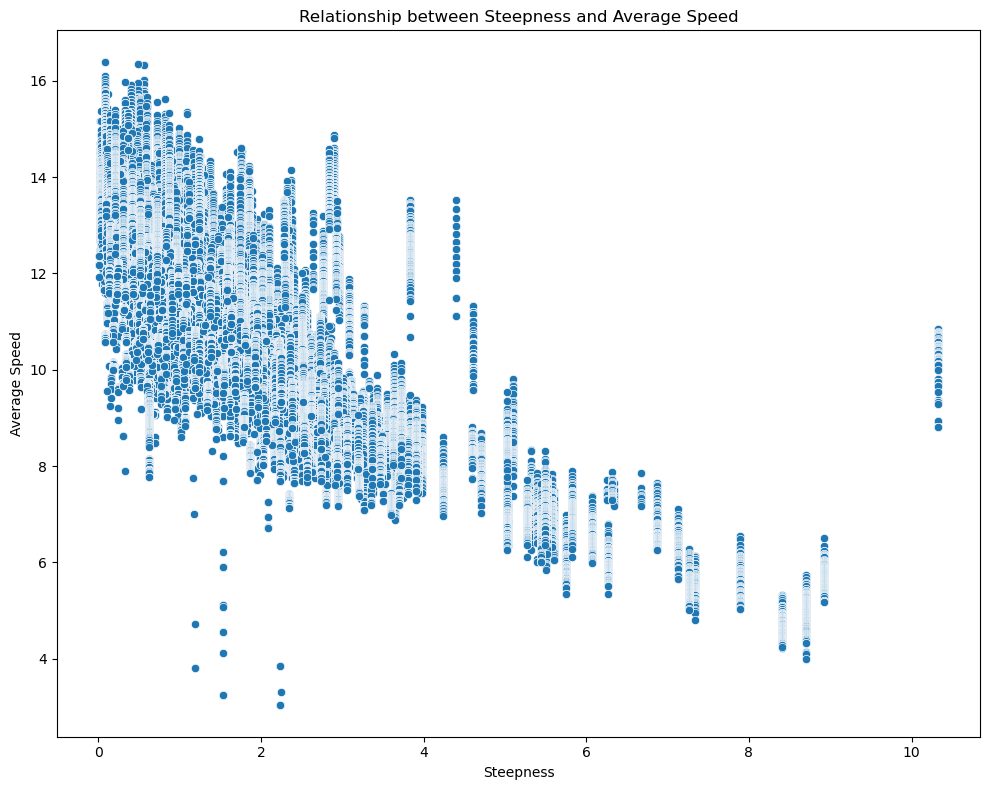

In [63]:
# plot the relationship between steepness and average speed

fig, ax = plt.subplots(figsize=(10, 8))
sns.scatterplot(data=races_df, x='steepness', y='average_speed', ax=ax)
ax.set_title('Relationship between Steepness and Average Speed')
ax.set_xlabel('Steepness')
ax.set_ylabel('Average Speed')
plt.tight_layout()
plt.show()

Well, seems that steeper tracks make it more difficult to keep an higher speed.

Let's check the stamina index we computed

In [64]:
races_df['stamina_index'].describe()

count    454730.000000
mean          7.651611
std           5.021724
min           0.046740
25%           6.211045
50%           7.431053
75%           8.751598
max         117.639589
Name: stamina_index, dtype: float64

Quite a weird difference between the maximum value and the third quantile. A violinplot might help

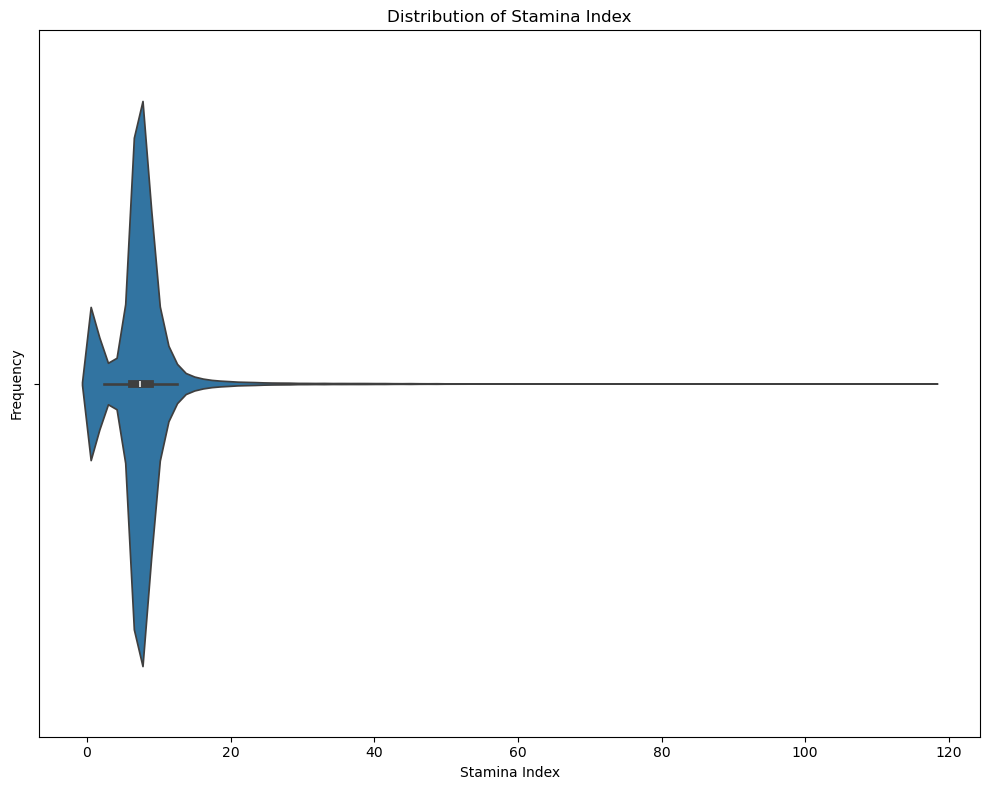

In [65]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.violinplot(data=races_df, x='stamina_index', ax=ax)
ax.set_title('Distribution of Stamina Index')
ax.set_xlabel('Stamina Index')
ax.set_ylabel('Frequency')
plt.tight_layout()
plt.show()

What a nice manta ray! Let's check an histogram without the exceptional riders

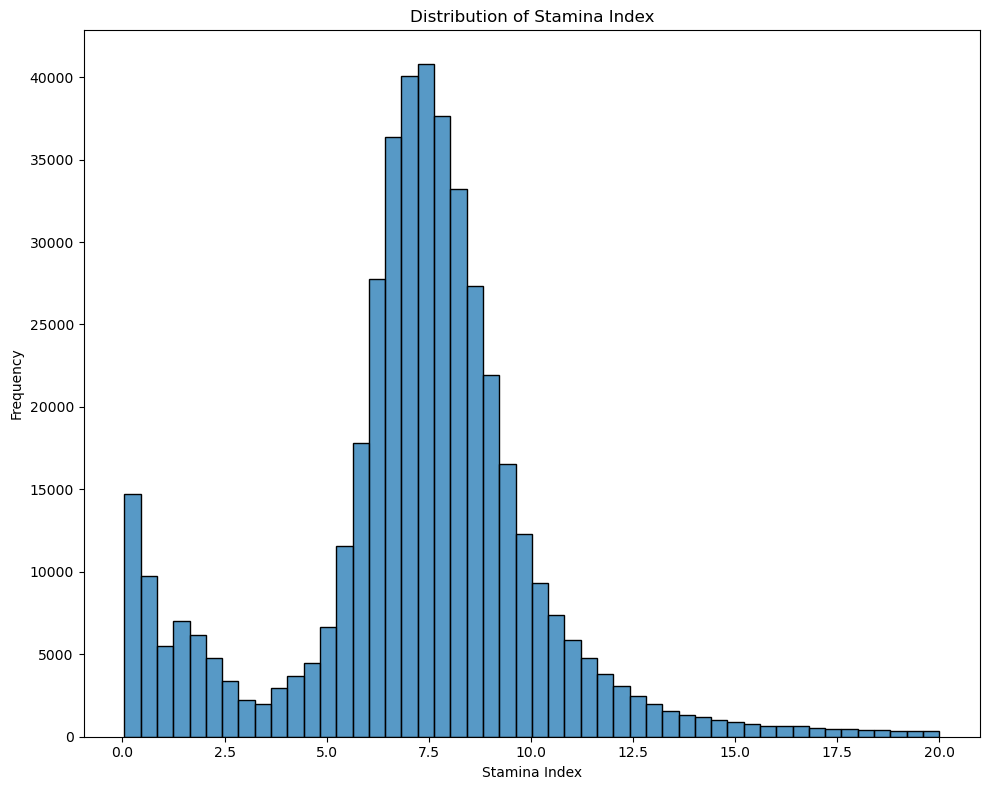

In [66]:
# plot the stamina index

fig, ax = plt.subplots(figsize=(10, 8))
sns.histplot(data=races_df[races_df['stamina_index'] < 20], x='stamina_index', bins=50, kde=False, ax=ax)
ax.set_title('Distribution of Stamina Index')
ax.set_xlabel('Stamina Index')
ax.set_ylabel('Frequency')
plt.tight_layout()
plt.show()

Seems like the performances fit a bimodal. The values tending more towards 0 are probably just the molar aggregate of subpar performances (bad positions alongside mediocre groups in flat, small tracks)

Let's compute a mean stamina index for each cyclist.

In [67]:
# compute a mean stamina index for each cyclist

mean_stamina_index = races_df.groupby('cyclist')['stamina_index'].mean().reset_index()

# merge the mean stamina index with cyclist_df
cyclist_df = cyclist_df.merge(mean_stamina_index, how='left', left_on='_url', right_on='cyclist')

In [68]:
cyclist_df['stamina_index'].describe()

count    4703.000000
mean        7.557249
std         2.429991
min         0.179735
25%         6.542600
50%         7.066765
75%         7.958945
max        70.167143
Name: stamina_index, dtype: float64

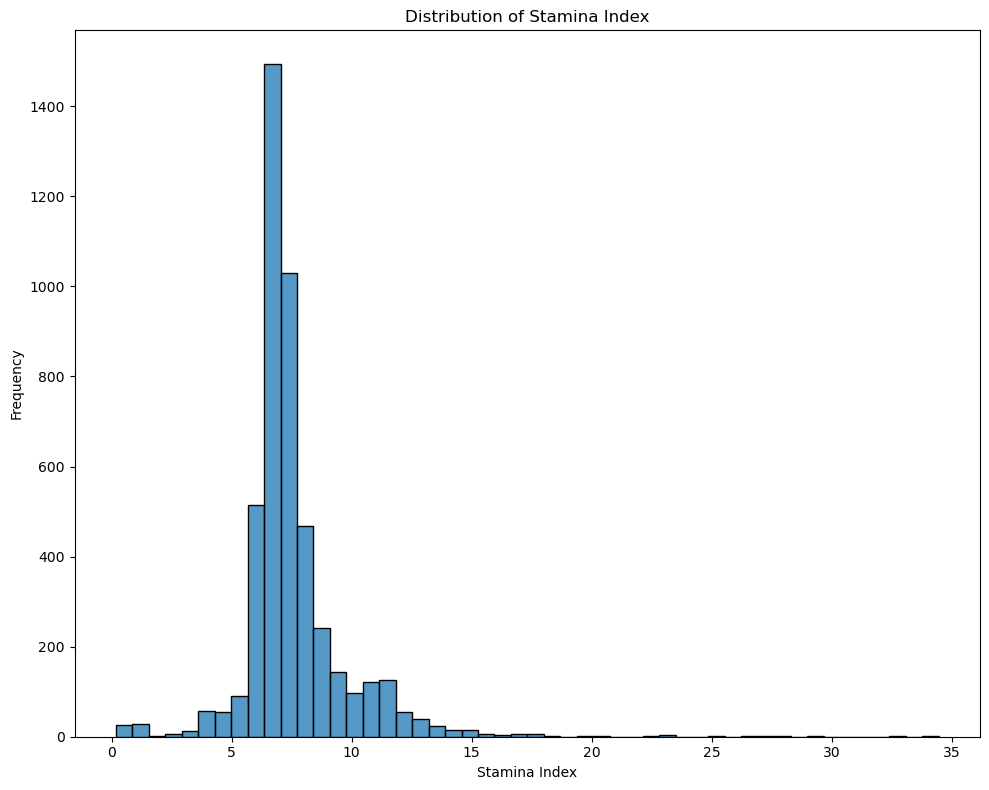

In [69]:
# plot the stamina index

fig, ax = plt.subplots(figsize=(10, 8))
sns.histplot(data=cyclist_df[cyclist_df['stamina_index'] < 40], x='stamina_index', bins=50, kde=False, ax=ax)
ax.set_title('Distribution of Stamina Index')
ax.set_xlabel('Stamina Index')
ax.set_ylabel('Frequency')
plt.tight_layout()
plt.show()

As we can see, there is clearly a giant mass of cyclists between 6 and 8. Aside the great deal of people, we have a few exceptional cyclists with a lot of stamina (or nor too many races).

## Dataset cleaning

Here we should copy the cleaning notebook because we have here many added feature that are not in the other notebook but that we need in the final cleaned dataset

The delta has already been discussed in an appropriate notebook so here we'll just report the cleaning process

In [70]:
initial_len = races_df.shape[0]
races_df = delta_based_dataset_cleaning(races_df)
final_len = races_df.shape[0]
print(f"removed lines {-final_len-(-initial_len)}")

removed lines 81487


just a reminder of why these are not useful: is_cobbled is always false; is_gravel is always false; cyclist_team can change from year to year and there were some considerations about the fact that the name is just the name of the sponsor (so the team can be the same but with different name); average_temperature is almost always null; Unnamed: 0 is a column created for error somewhere

In [73]:
columns_to_drop = [
    'is_cobbled',
    'is_gravel',
    'cyclist_team',
    'average_temperature',
]
races_df = races_df.drop(columns=columns_to_drop)
races_df.head()


,_url,name,stage,stage_type,points,uci_points,length,climb_total,profile,startlist_quality,...,age_performance_index,quality_adjusted_points,normalized_length,normalized_quality,normalized_steepness,profile_adjustment,normalized_time,stamina_index,season_name,length_category
0,tour-de-france/1978/stage-6,Tour de France,stage-6,RR,100.0,NaN,162000.0,1101.0,1.0,1241,...,57.145880,3223.547139,0.47929,6.062531,0.065817,0.0,0.207085,41.744580,summer,Short
1,tour-de-france/1978/stage-6,Tour de France,stage-6,RR,70.0,NaN,162000.0,1101.0,1.0,1241,...,41.364108,1901.216954,0.47929,6.062531,0.065817,0.0,0.207085,23.827646,summer,Short
2,tour-de-france/1978/stage-6,Tour de France,stage-6,RR,50.0,NaN,162000.0,1101.0,1.0,1241,...,19.719520,1019.663498,0.47929,6.062531,0.065817,0.0,0.207085,17.855334,summer,Short
3,tour-de-france/1978/stage-6,Tour de France,stage-6,RR,40.0,NaN,162000.0,1101.0,1.0,1241,...,13.994040,578.886770,0.47929,6.062531,0.065817,0.0,0.207085,14.869178,summer,Short
4,tour-de-france/1978/stage-6,Tour de France,stage-6,RR,32.0,NaN,162000.0,1101.0,1.0,1241,...,4.922776,226.265387,0.47929,6.062531,0.065817,0.0,0.207085,13.077485,summer,Short


#### Saving the dataset

In [74]:
races_df.to_csv(os.path.join('dataset', 'races_cleaned.csv'), index=False)
cyclist_df.to_csv(os.path.join('dataset', 'cyclists_cleaned.csv'), index=False)

## Correlations

Now, onto, the correlations!

In [75]:
merged_df.drop(columns=['norm_points', 'normalized_length', 'normalized_quality', 'normalized_steepness', 'profile_adjustment', 'normalized_time'], inplace=True)

In [76]:
normalized_dataset, normalization_scalers_dataset = center_and_scale(merged_df)
corr = correlations(normalized_dataset)
corr

,birth_year,weight,height,bmi,race_count,total_points,points,uci_points,length,climb_total,...,cyclist_age,delta,time_seconds,average_speed,steepness,season,age_performance_index,quality_adjusted_points,stamina_index,correlation_type
birth_year,1.000000,-0.048803,0.084663,-0.162113,0.075368,-0.089351,-0.097800,0.198348,-0.064112,0.046401,...,-0.145400,0.077881,-0.082867,0.064969,0.048096,-0.073991,0.032995,0.011606,-0.031492,kendall
weight,-0.048803,1.000000,0.562259,0.462301,-0.042833,0.011991,0.033811,0.019580,0.033074,-0.021358,...,0.037791,0.071509,0.038143,-0.005755,-0.032897,-0.001110,0.032249,0.046002,-0.017697,kendall
height,0.084663,0.562259,1.000000,-0.010594,-0.017339,-0.064742,-0.032199,0.015617,0.009760,-0.004028,...,-0.008855,0.057732,0.010093,0.005320,-0.008609,-0.009803,-0.000719,0.005048,-0.025418,kendall
bmi,-0.162113,0.462301,-0.010594,1.000000,-0.042309,0.084587,0.076261,0.005633,0.036273,-0.026266,...,0.064869,0.040922,0.043267,-0.013893,-0.037672,0.007506,0.042476,0.055322,0.000634,kendall
race_count,0.075368,-0.042833,-0.017339,-0.042309,1.000000,0.474431,0.040183,-0.064907,-0.021248,0.024476,...,0.241153,-0.057398,-0.034741,0.040841,0.020375,0.026845,0.036343,0.028259,0.051599,kendall
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
steepness,0.071922,-0.048133,-0.012615,-0.056390,0.030571,0.000678,0.028758,-0.008434,-0.109981,0.762462,...,0.003055,0.550002,0.183787,-0.674704,1.000000,0.061783,-0.029140,-0.033709,-0.122164,spearman
season,-0.095181,-0.001370,-0.012292,0.009665,0.034463,0.042281,0.108628,0.071963,-0.053480,0.068260,...,-0.010571,0.092351,-0.044443,-0.003785,0.061783,1.000000,-0.026535,-0.076694,0.017188,spearman
age_performance_index,0.046982,0.047063,-0.000749,0.063789,0.054007,0.204396,0.822647,0.497462,0.088272,0.010916,...,-0.096749,-0.232589,0.061383,0.061294,-0.029140,-0.026535,1.000000,0.906802,0.521930,spearman
quality_adjusted_points,0.013987,0.066664,0.007324,0.082064,0.042147,0.197432,0.785026,0.470080,0.020113,-0.013135,...,0.014324,-0.242085,-0.002076,0.042924,-0.033709,-0.076694,0.906802,1.000000,0.442832,spearman


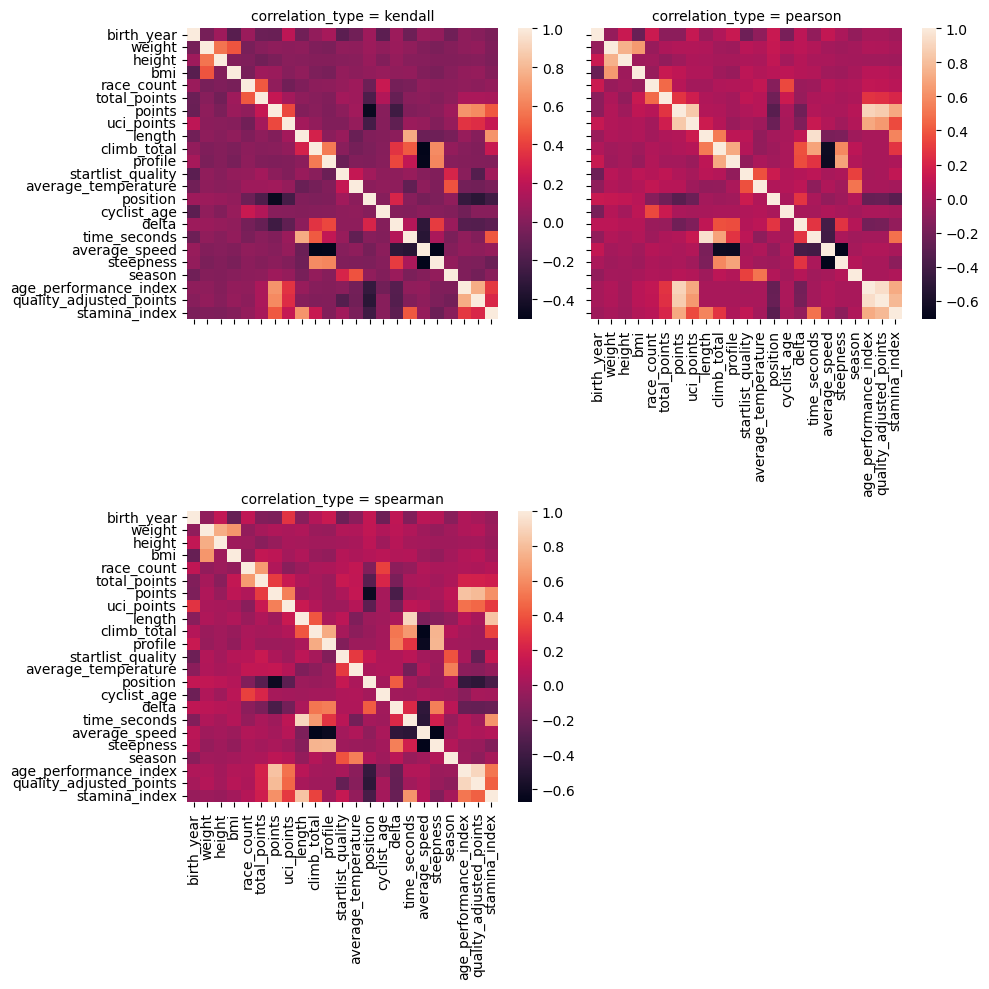

In [77]:
g = sns.FacetGrid(corr, col="correlation_type", col_wrap=2, height=5, aspect=1)
g.map_dataframe(lambda data, color: sns.heatmap(data[data.columns[:-1]]))

## Rewatch

Let's analyze how some plot changed after all this work

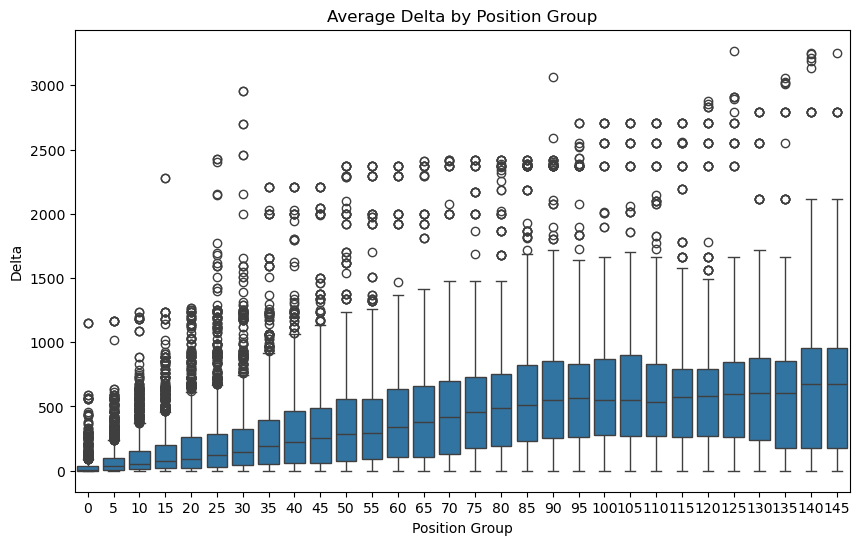

In [78]:
length_range = (250000, 2500000)  # Example length range in meters
# we still consider a subrange of the races because the delta is much
# influenced by this and so is expected a hig variance if we consider all the races
filtered_df = races_df[(races_df['length'] >= length_range[0]) & (races_df['length'] <= length_range[1])]
filtered_df = filtered_df[(filtered_df['stage_type'] == 'RR') & (filtered_df['stage'] != 'prologue')]
filtered_df = filtered_df[filtered_df['position'] < 150]
# Create a new column 'position_group' that groups positions in intervals of 5
filtered_df = filtered_df.assign(position_group=(filtered_df['position'] // 5) * 5)

# Plot the box plot for the average delta by position group
plt.figure(figsize=(10, 6))
sns.boxplot(data=filtered_df, x='position_group', y='delta')
plt.title('Average Delta by Position Group')
plt.xlabel('Position Group')
plt.ylabel('Delta')
plt.show()

This is pretty much the same :( But some arbitrary cleaning was already done in the previous version, at least we can say tath this one is more 'theoretically grounded'

Anyway, we can see that the delta increse almost logarithmic, this means (personal interpretation to be discussed) that more or less all the athletes are on the same level